In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [2]:
def calculate_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2_spei1 = r2_score(y_true, y_pred)
  return mae, mse, rmse, r2_spei1

## Data Preprocessing

### Helper Functions

In [4]:
# graph data
def graph_spei_data(data, timescale):
  plt.figure(figsize=(24, 7))
  plt.plot(data['spei'], c='cyan')
  title = f"SPEI on {timescale}-Month Timescale"
  plt.title(title)
  plt.xlabel("Date")
  plt.ylabel(f"SPEI-{timescale}")
  plt.figure(figsize=(18, 6))
  plt.show()

In [3]:
def create_samples(data, time_steps=12):
  X, y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps)])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

In [115]:
def normalize_data(X_train, y_train, X_val, y_val, X_test, y_test):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_train_flat = X_train.reshape(-1, 1)
  scaler.fit(X_train_flat)    # fit scaler on training data only

  # transform train data
  X_train_scaled = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
  y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()

  # transform val data
  X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
  y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()

  # transform test data
  X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
  y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

  return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, scaler

### SPEI-1

In [125]:
# load data
spei1_df = pd.read_csv('/content/SPEI_1_MonthTimescale_1950_2013_Fresno.csv')
spei1_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75  0.568691
1  1950-02-15 -119.75  36.75 -0.323044
2  1950-03-16 -119.75  36.75 -0.148050
3  1950-04-16 -119.75  36.75 -0.585959
4  1950-05-16 -119.75  36.75 -0.860067

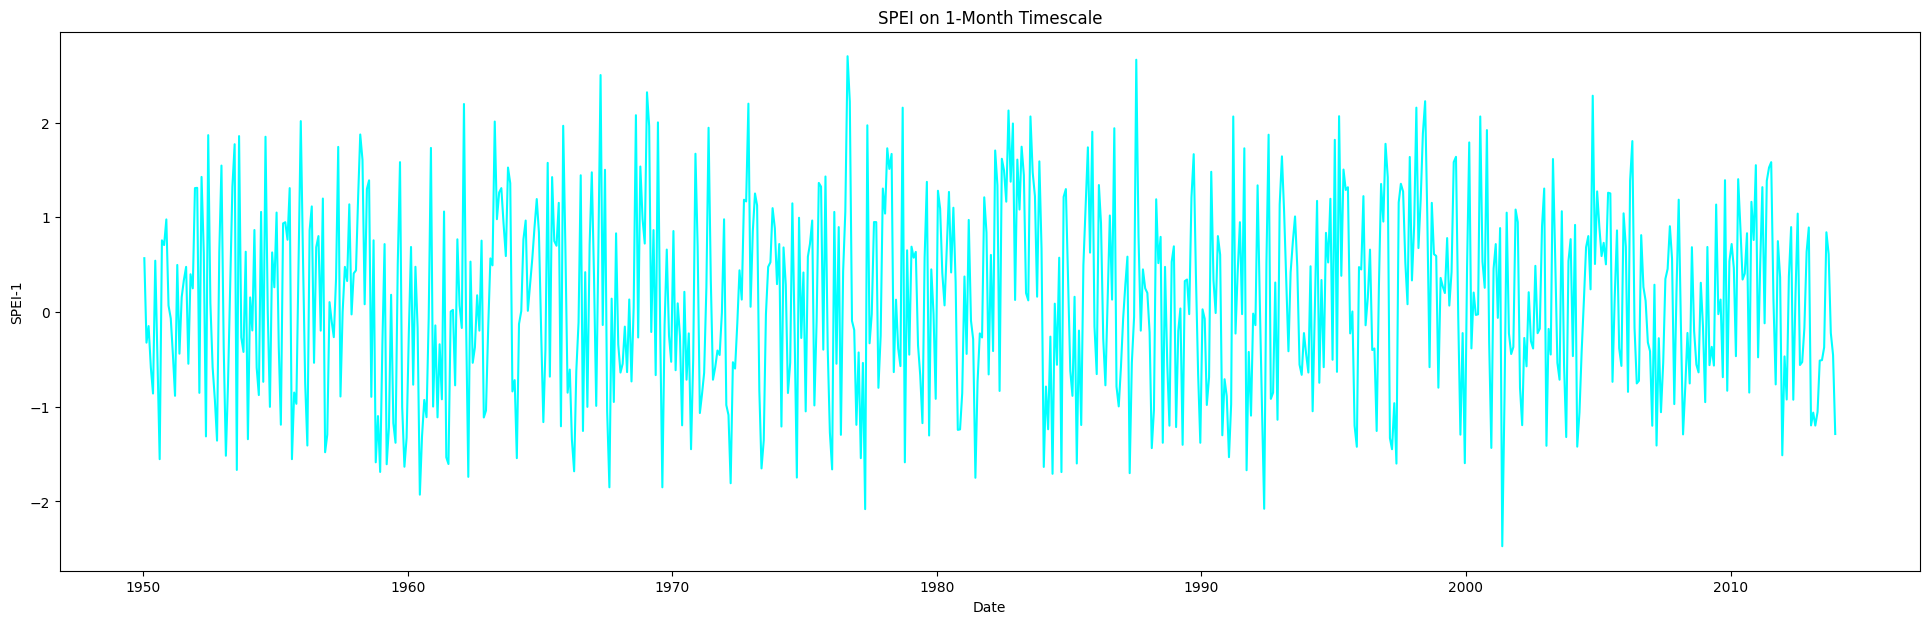

<Figure size 1800x600 with 0 Axes>

In [126]:
spei1_df['time'] = pd.to_datetime(spei1_df['time'], format='%Y-%m-%d')
spei1_df.set_index('time', inplace=True)
graph_spei_data(spei1_df, 1)

In [130]:
# --- split into train/val/test --- #

# get data samples
time_steps = 6
X_spei1, y_spei1 = create_samples(spei1_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei1 = X_spei1.reshape((X_spei1.shape[0], X_spei1.shape[1], 1))

# get splits
train_size = int(len(X_spei1) * 0.8)
val_size = int(len(X_spei1) * 0.1)

X_train_spei1, y_train_spei1 = X_spei1[:train_size], y_spei1[:train_size]
X_val_spei1, y_val_spei1 = X_spei1[train_size:train_size + val_size], y_spei1[train_size:train_size + val_size]
X_test_spei1, y_test_spei1 = X_spei1[train_size + val_size:], y_spei1[train_size + val_size:]

print(f"Training splits (80%):  X_train_spei1 = {X_train_spei1.shape} | y_train_spei1 = {y_train_spei1.shape}")
print(f"Validation splits (10%):  X_val_spei1 = {X_val_spei1.shape} | y_val_spei1 = {y_val_spei1.shape}")
print(f"Test splits (10%):  X_test_spei1 = {X_test_spei1.shape} | y_test_spei1 = {y_test_spei1.shape}")

Training splits (80%):  X_train_spei1 = (609, 6, 1) | y_train_spei1 = (609,)
Validation splits (10%):  X_val_spei1 = (76, 6, 1) | y_val_spei1 = (76,)
Test splits (10%):  X_test_spei1 = (77, 6, 1) | y_test_spei1 = (77,)


In [131]:
# normalize data
X_train_spei1, y_train_spei1, X_val_spei1, y_val_spei1, X_test_spei1, y_test_spei1, scaler_spei1 = normalize_data(X_train_spei1,
                                                                                                                  y_train_spei1,
                                                                                                                  X_val_spei1,
                                                                                                                  y_val_spei1,
                                                                                                                  X_test_spei1,
                                                                                                                  y_test_spei1)

In [132]:
X_train_spei1[0], y_train_spei1[0]  # example sample

(array([[ 0.10813929],
        [-0.26485058],
        [-0.19165515],
        [-0.37482099],
        [-0.48947366],
        [ 0.09703159]]),
 np.float64(-0.34347573949382243))

### SPEI-3

In [137]:
# load data
spei3_df = pd.read_csv('/content/SPEI_3_MonthTimescale_1950_2013_Fresno.csv')
spei3_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75 -0.113825
1  1950-02-15 -119.75  36.75 -0.082312
2  1950-03-16 -119.75  36.75 -0.025755
3  1950-04-16 -119.75  36.75 -0.624708
4  1950-05-16 -119.75  36.75 -0.823265

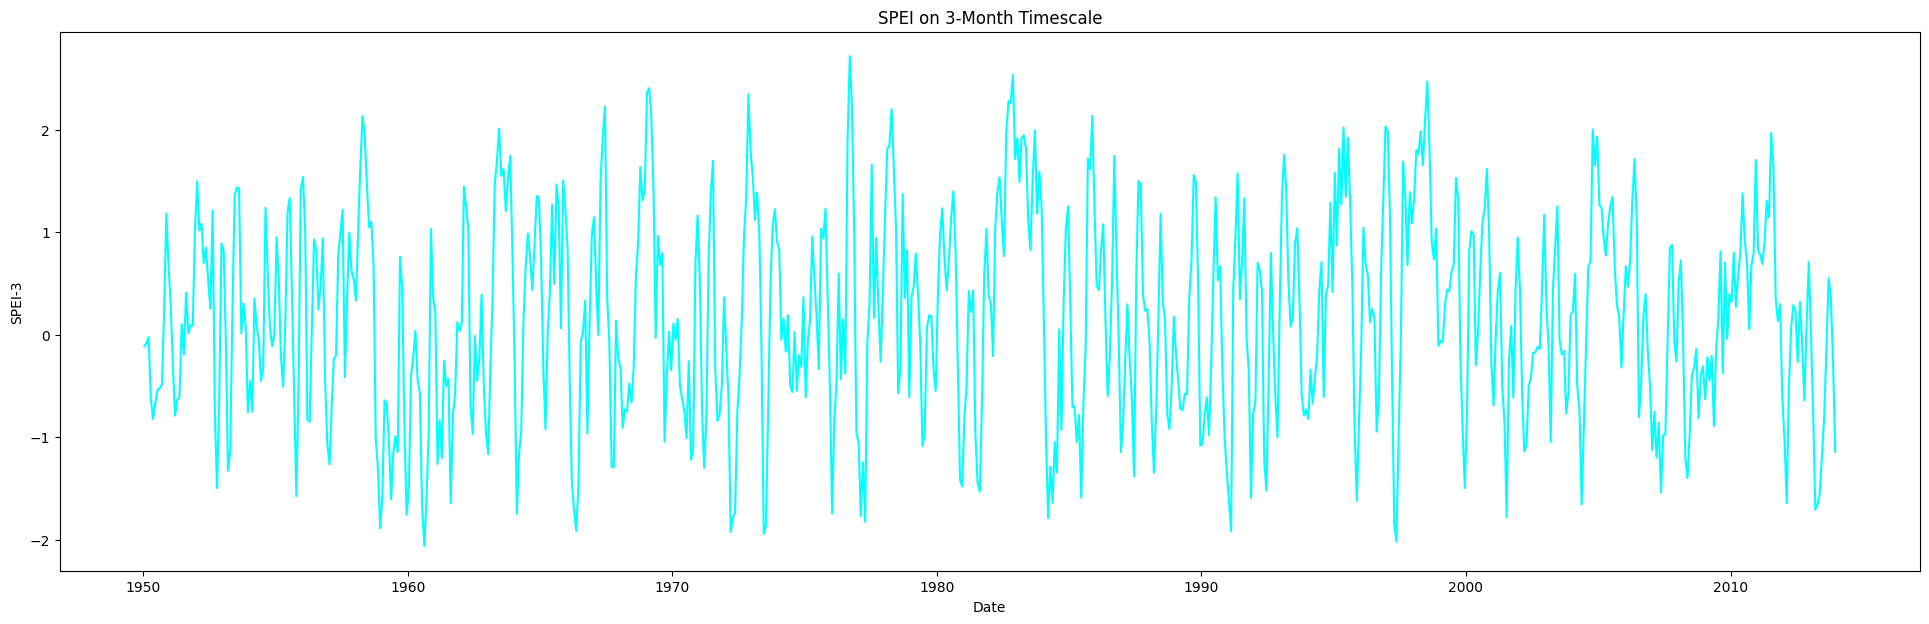

<Figure size 1800x600 with 0 Axes>

In [138]:
spei3_df['time'] = pd.to_datetime(spei3_df['time'], format='%Y-%m-%d')
spei3_df.set_index('time', inplace=True)
graph_spei_data(spei3_df, 3)

In [139]:
# --- split into train/val/test --- #

# get data samples
time_steps = 3
X_spei3, y_spei3 = create_samples(spei3_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei3 = X_spei3.reshape((X_spei3.shape[0], X_spei3.shape[1], 1))

# get splits
train_size = int(len(X_spei3) * 0.8)
val_size = int(len(X_spei3) * 0.1)

X_train_spei3, y_train_spei3 = X_spei3[:train_size], y_spei3[:train_size]
X_val_spei3, y_val_spei3 = X_spei3[train_size:train_size + val_size], y_spei3[train_size:train_size + val_size]
X_test_spei3, y_test_spei3 = X_spei3[train_size + val_size:], y_spei3[train_size + val_size:]

print(f"Training splits (80%):  X_train_spei3 = {X_train_spei3.shape} | y_train_spei3 = {y_train_spei3.shape}")
print(f"Validation splits (10%):  X_val_spei3 = {X_val_spei3.shape} | y_val_spei3 = {y_val_spei3.shape}")
print(f"Test splits (10%):  X_test_spei3 = {X_test_spei3.shape} | y_test_spei3 = {y_test_spei3.shape}")

Training splits (80%):  X_train_spei3 = (612, 3, 1) | y_train_spei3 = (612,)
Validation splits (10%):  X_val_spei3 = (76, 3, 1) | y_val_spei3 = (76,)
Test splits (10%):  X_test_spei3 = (77, 3, 1) | y_test_spei3 = (77,)


In [140]:
# normalize data
X_train_spei3, y_train_spei3, X_val_spei3, y_val_spei3, X_test_spei3, y_test_spei3, scaler_spei3 = normalize_data(X_train_spei3,
                                                                                                                  y_train_spei3,
                                                                                                                  X_val_spei3,
                                                                                                                  y_val_spei3,
                                                                                                                  X_test_spei3,
                                                                                                                  y_test_spei3)

In [141]:
X_train_spei3[0], y_train_spei3[0]  # example sample

(array([[-0.18387082],
        [-0.17068105],
        [-0.14700908]]),
 np.float64(-0.3977024277924654))

### SPEI-6

In [165]:
# load data
spei6_df = pd.read_csv('/content/SPEI_6_MonthTimescale_1950_2013_Fresno.csv')
spei6_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75 -0.177393
1  1950-02-15 -119.75  36.75 -0.520186
2  1950-03-16 -119.75  36.75 -0.425508
3  1950-04-16 -119.75  36.75 -0.482449
4  1950-05-16 -119.75  36.75 -0.595851

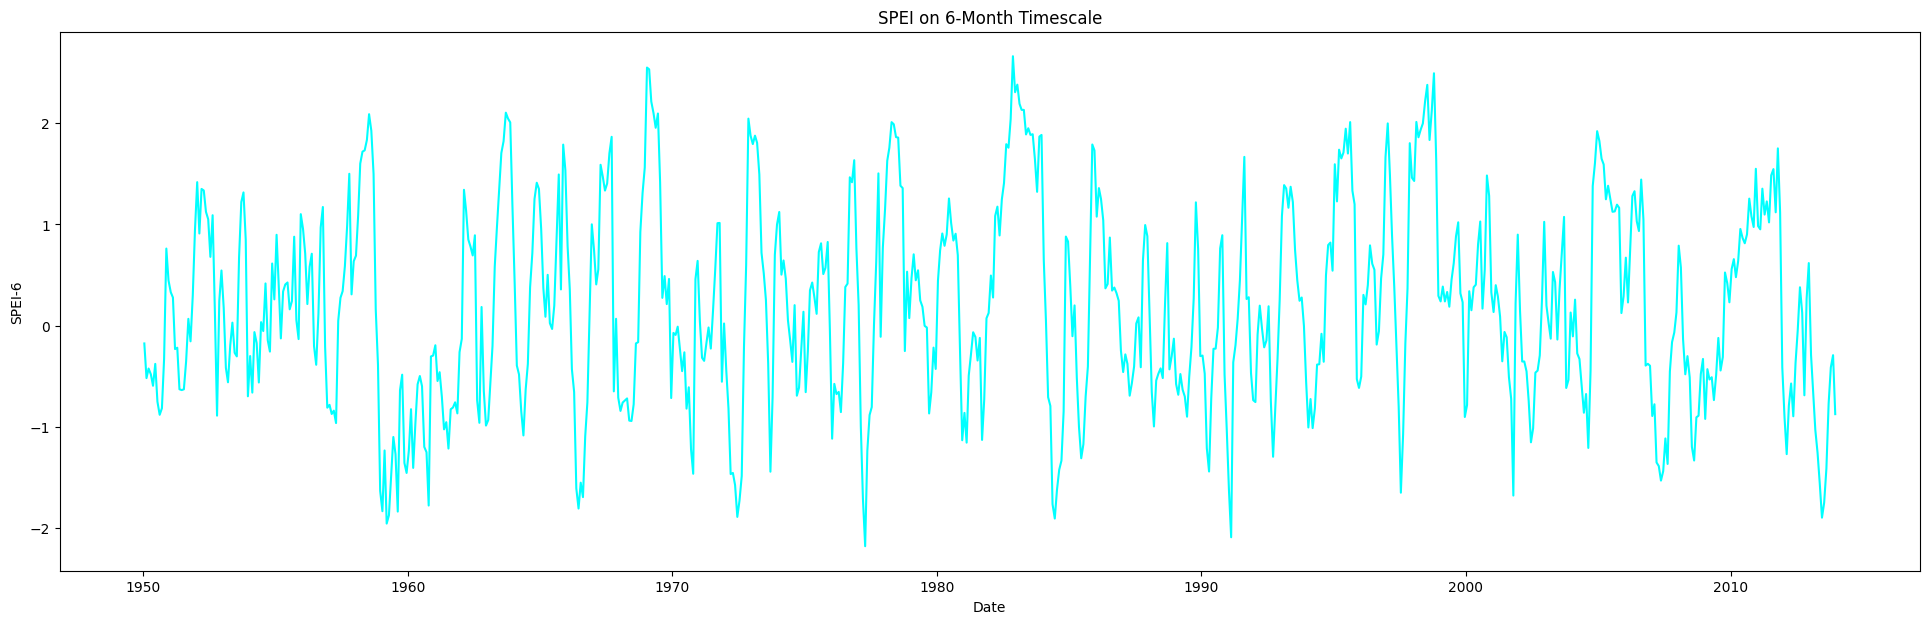

<Figure size 1800x600 with 0 Axes>

In [166]:
spei6_df['time'] = pd.to_datetime(spei6_df['time'], format='%Y-%m-%d')
spei6_df.set_index('time', inplace=True)
graph_spei_data(spei6_df, 6)

In [167]:
# --- split into train/val/test --- #

# get data samples
time_steps = 5
X_spei6, y_spei6 = create_samples(spei6_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei6 = X_spei6.reshape((X_spei6.shape[0], X_spei6.shape[1], 1))

# get splits
train_size = int(len(X_spei6) * 0.8)
val_size = int(len(X_spei6) * 0.1)

X_train_spei6, y_train_spei6 = X_spei6[:train_size], y_spei6[:train_size]
X_val_spei6, y_val_spei6 = X_spei6[train_size:train_size + val_size], y_spei6[train_size:train_size + val_size]
X_test_spei6, y_test_spei6 = X_spei6[train_size + val_size:], y_spei6[train_size + val_size:]

print(f"Training splits (80%):  X_train_spei6 = {X_train_spei6.shape} | y_train_spei6 = {y_train_spei6.shape}")
print(f"Validation splits (10%):  X_val_spei6 = {X_val_spei6.shape} | y_val_spei6 = {y_val_spei6.shape}")
print(f"Test splits (10%):  X_test_spei6 = {X_test_spei6.shape} | y_test_spei6 = {y_test_spei6.shape}")

Training splits (80%):  X_train_spei6 = (610, 5, 1) | y_train_spei6 = (610,)
Validation splits (10%):  X_val_spei6 = (76, 5, 1) | y_val_spei6 = (76,)
Test splits (10%):  X_test_spei6 = (77, 5, 1) | y_test_spei6 = (77,)


In [168]:
# normalize data
X_train_spei6, y_train_spei6, X_val_spei6, y_val_spei6, X_test_spei6, y_test_spei6, scaler_spei6 = normalize_data(X_train_spei6,
                                                                                                                  y_train_spei6,
                                                                                                                  X_val_spei6,
                                                                                                                  y_val_spei6,
                                                                                                                  X_test_spei6,
                                                                                                                  y_test_spei6)

In [169]:
X_train_spei6[0], y_train_spei6[0]  # example sample

(array([[-0.1723716 ],
        [-0.31380863],
        [-0.27474426],
        [-0.29823832],
        [-0.3450278 ]]),
 np.float64(-0.2557617421784088))

### SPEI-12

In [142]:
# load data
spei12_df = pd.read_csv('/content/SPEI_12_MonthTimescale_1950_2013_Fresno.csv')
spei12_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75 -0.291648
1  1950-02-15 -119.75  36.75 -0.343679
2  1950-03-16 -119.75  36.75 -0.756500
3  1950-04-16 -119.75  36.75 -0.402883
4  1950-05-16 -119.75  36.75 -0.857081

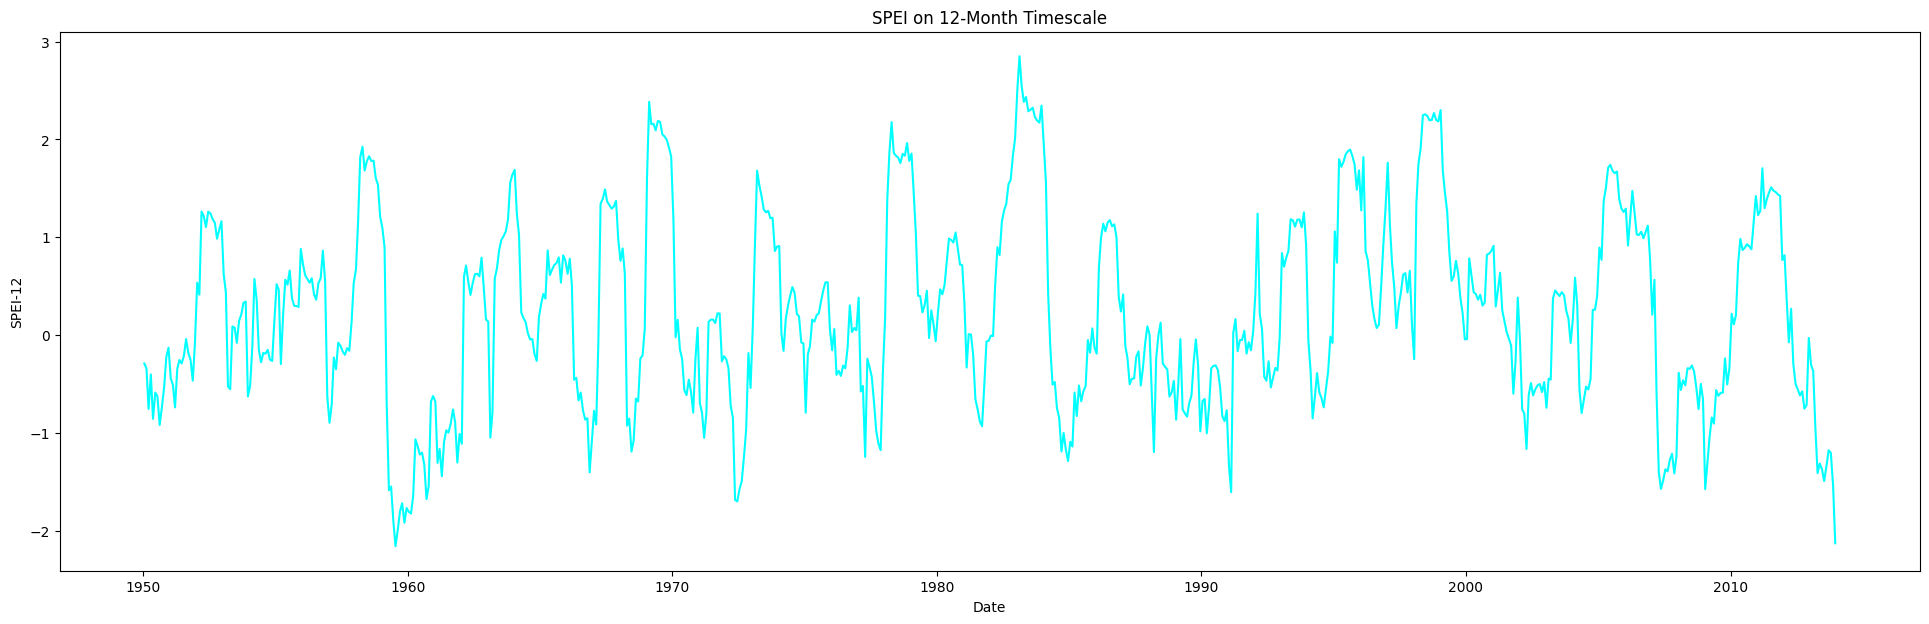

<Figure size 1800x600 with 0 Axes>

In [143]:
spei12_df['time'] = pd.to_datetime(spei12_df['time'], format='%Y-%m-%d')
spei12_df.set_index('time', inplace=True)
graph_spei_data(spei12_df, 12)

In [144]:
# --- split into train/val/test --- #

# get data samples
time_steps = 6
X_spei12, y_spei12 = create_samples(spei12_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei12 = X_spei12.reshape((X_spei12.shape[0], X_spei12.shape[1], 1))

# get splits
train_size = int(len(X_spei12) * 0.8)
val_size = int(len(X_spei12) * 0.1)

X_train_spei12, y_train_spei12 = X_spei12[:train_size], y_spei12[:train_size]
X_val_spei12, y_val_spei12 = X_spei12[train_size:train_size + val_size], y_spei12[train_size:train_size + val_size]
X_test_spei12, y_test_spei12 = X_spei12[train_size + val_size:], y_spei12[train_size + val_size:]

print(f"Training splits (80%):  X_train_spei12 = {X_train_spei12.shape} | y_train_spei12 = {y_train_spei12.shape}")
print(f"Validation splits (10%):  X_val_spei12 = {X_val_spei12.shape} | y_val_spei12 = {y_val_spei12.shape}")
print(f"Test splits (10%):  X_test_spei12 = {X_test_spei12.shape} | y_test_spei12 = {y_test_spei12.shape}")

Training splits (80%):  X_train_spei12 = (609, 6, 1) | y_train_spei12 = (609,)
Validation splits (10%):  X_val_spei12 = (76, 6, 1) | y_val_spei12 = (76,)
Test splits (10%):  X_test_spei12 = (77, 6, 1) | y_test_spei12 = (77,)


In [145]:
# normalize data
X_train_spei12, y_train_spei12, X_val_spei12, y_val_spei12, X_test_spei12, y_test_spei12, scaler_spei12 = normalize_data(X_train_spei12,
                                                                                                                  y_train_spei12,
                                                                                                                  X_val_spei12,
                                                                                                                  y_val_spei12,
                                                                                                                  X_test_spei12,
                                                                                                                  y_test_spei12)

In [146]:
X_train_spei12[0], y_train_spei12[0]  # example sample

(array([[-0.25428211],
        [-0.27504714],
        [-0.43980007],
        [-0.29867463],
        [-0.47994073],
        [-0.37269773]]),
 np.float64(-0.3888320735117884))

## LSTM | SPEI-1

### Model Training

In [147]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei1 = Sequential()
LSTM_model_spei1.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei1.shape[1], 1)))
LSTM_model_spei1.add(LSTM(units=64, activation='relu'))
LSTM_model_spei1.add(Dense(1))
LSTM_model_spei1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei1 = LSTM_model_spei1.fit(X_train_spei1,
                              y_train_spei1,
                              batch_size=16,
                              validation_data=(X_val_spei1, y_val_spei1),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1821 - val_loss: 0.1405
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1773 - val_loss: 0.1401
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1771 - val_loss: 0.1397
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1769 - val_loss: 0.1395
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1767 - val_loss: 0.1391
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1765 - val_loss: 0.1389
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1764 - val_loss: 0.1388
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1762 - val_loss: 0.1385
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1759 - val_loss: 0.1385
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1757 - val_loss: 0.1386
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1754 - val_loss: 0.1388
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1753 - val_l

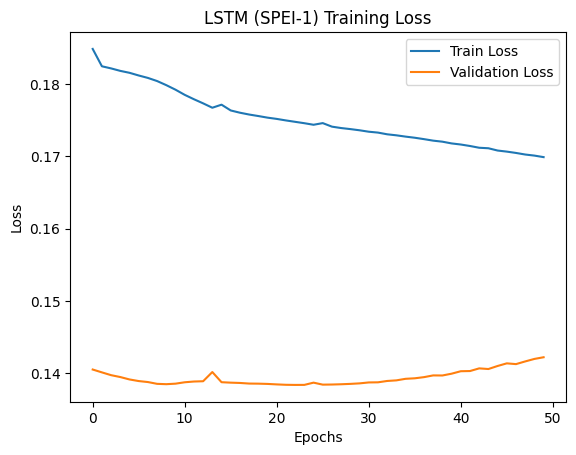

In [148]:
plt.plot(history_spei1.history['loss'], label='Train Loss')
plt.plot(history_spei1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM (SPEI-1) Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


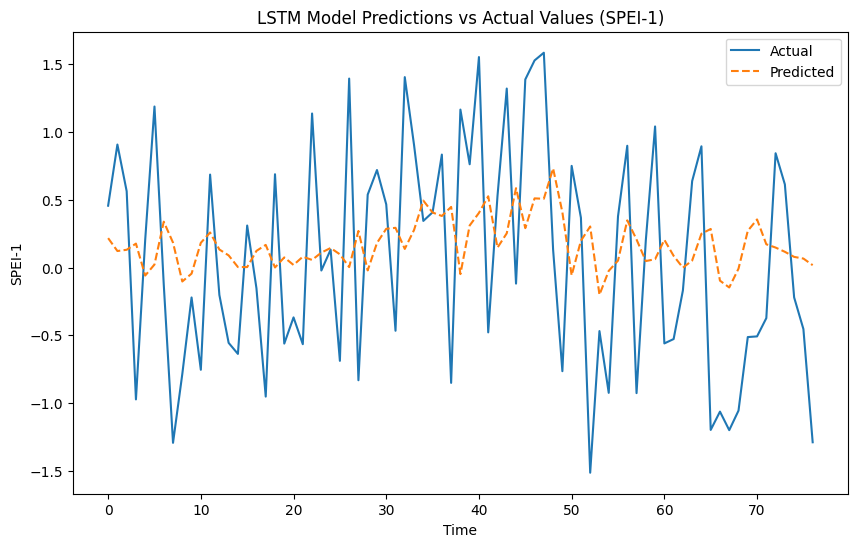

In [151]:
y_pred_spei1 = LSTM_model_spei1.predict(X_test_spei1) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei1 = scaler_spei1.inverse_transform(y_pred_spei1)
y_test_original_spei1 = scaler_spei1.inverse_transform(y_test_spei1.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei1, label="Actual")
plt.plot(y_pred_original_spei1, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-1")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-1)")
plt.show()

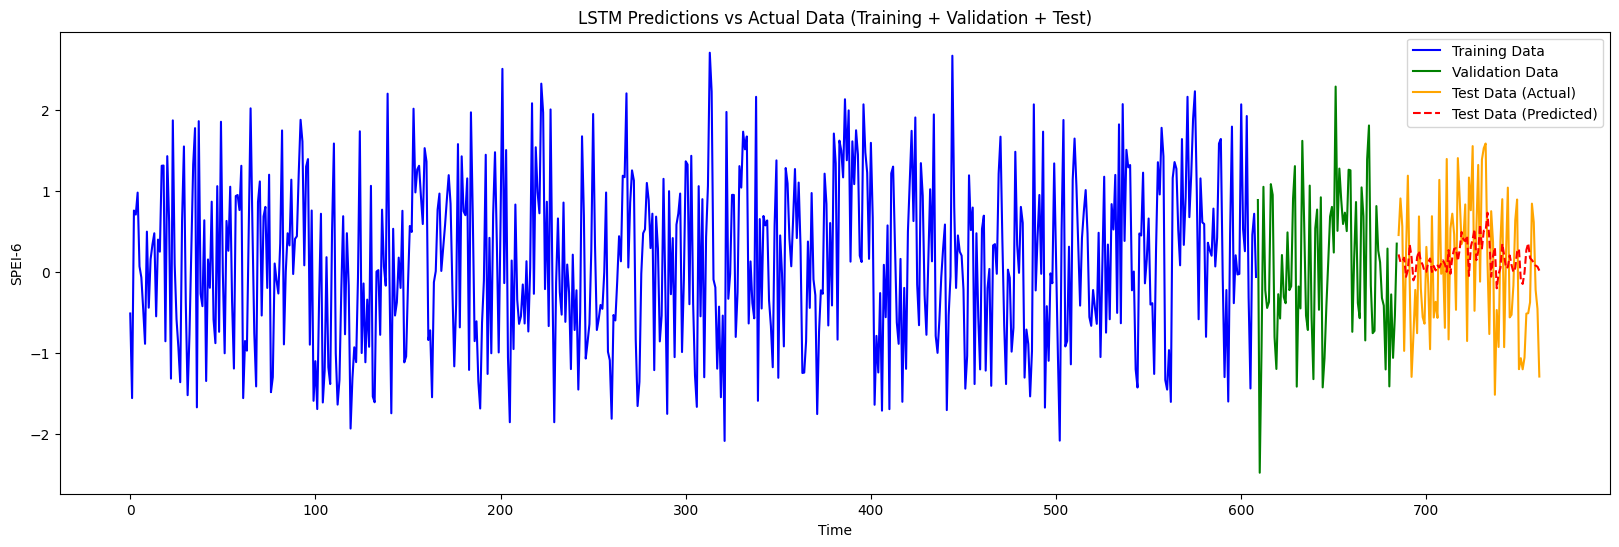

In [152]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
reversed_train_data_spei1 = scaler_spei1.inverse_transform(y_train_spei1.reshape(-1, 1))
reversed_val_data_spei1 = scaler_spei1.inverse_transform(y_val_spei1.reshape(-1, 1))
reversed_test_data_spei1 = scaler_spei1.inverse_transform(y_test_spei1.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((reversed_train_data_spei1, reversed_val_data_spei1, reversed_test_data_spei1), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(reversed_train_data_spei1, np.nan),
                                 np.full_like(reversed_val_data_spei1, np.nan),
                                 y_pred_original_spei1), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(reversed_train_data_spei1)), reversed_train_data_spei1, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(reversed_train_data_spei1), len(reversed_train_data_spei1) + len(reversed_val_data_spei1)), reversed_val_data_spei1, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(reversed_train_data_spei1) + len(reversed_val_data_spei1), len(actual_data)), reversed_test_data_spei1, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(reversed_train_data_spei1) + len(reversed_val_data_spei1), len(actual_data)), y_pred_original_spei1, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-6')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

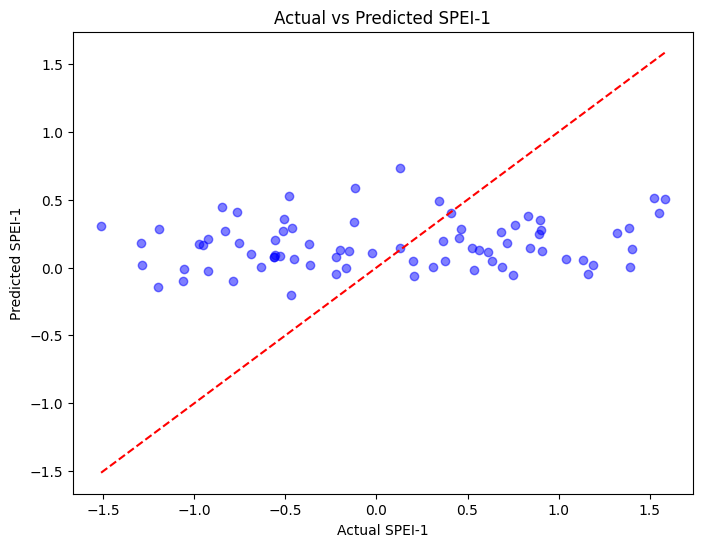

In [153]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei1, y_pred_original_spei1, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei1), max(y_test_original_spei1)], [min(y_test_original_spei1), max(y_test_original_spei1)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-1')
plt.ylabel('Predicted SPEI-1')
plt.title('Actual vs Predicted SPEI-1')
plt.show()

#### Metrics

In [154]:
mae_spei1, mse_spei1, rmse_spei1, r2_spei1 = calculate_metrics(y_test_original_spei1, y_pred_original_spei1)
print(f"Mean Absolute Error: {mae_spei1}")
print(f"Mean Squared Error: {mse_spei1}")
print(f"Root Mean Squared Error: {rmse_spei1}")
print(f"R^2 Score: {r2_spei1}")

Mean Absolute Error: 0.714516086321533
Mean Squared Error: 0.6663468452659823
Root Mean Squared Error: 0.8163007076231052
R^2 Score: 0.003931487861994931


## LSTM | SPEI-3

### Model Training

In [155]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei3 = Sequential()
LSTM_model_spei3.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei3.shape[1], 1)))
LSTM_model_spei3.add(LSTM(units=64, activation='relu'))
LSTM_model_spei3.add(Dense(1))
LSTM_model_spei3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei3 = LSTM_model_spei3.fit(X_train_spei3,
                              y_train_spei3,
                              batch_size=16,
                              validation_data=(X_val_spei3, y_val_spei3),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1665 - val_loss: 0.1277
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1508 - val_loss: 0.1057
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1285 - val_loss: 0.0886
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0990 - val_loss: 0.0690
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0882 - val_loss: 0.0642
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0787 - val_loss: 0.0639
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0782 - val_loss: 0.0634
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0774 - val_loss: 0.0633
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0772 - val_loss: 0.0633
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0770 - val_loss: 0.0633
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0769 - val_loss: 0.0633
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0768 - val_loss: 0.0

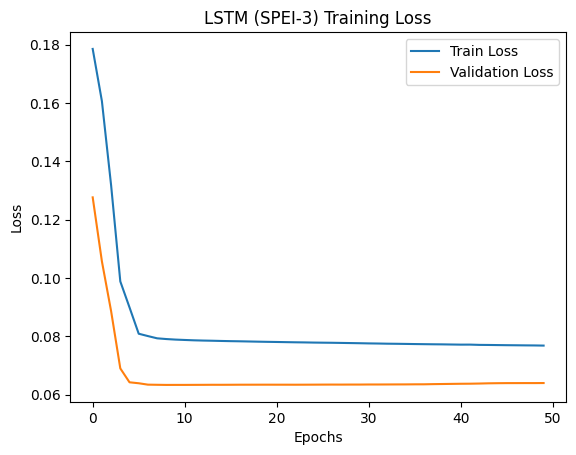

In [156]:
plt.plot(history_spei3.history['loss'], label='Train Loss')
plt.plot(history_spei3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM (SPEI-3) Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


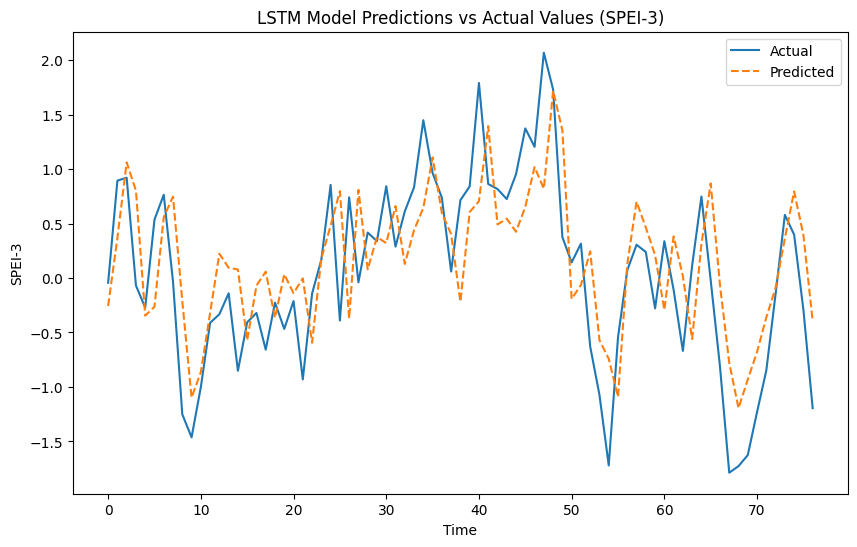

In [ ]:
y_pred_spei3 = LSTM_model_spei3.predict(X_test_spei3) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei3 = scaler_spei3.inverse_transform(y_pred_spei3)
y_test_original_spei3 = scaler_spei3.inverse_transform(y_test_spei3.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei3, label="Actual")
plt.plot(y_pred_original_spei3, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-3")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-3)")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


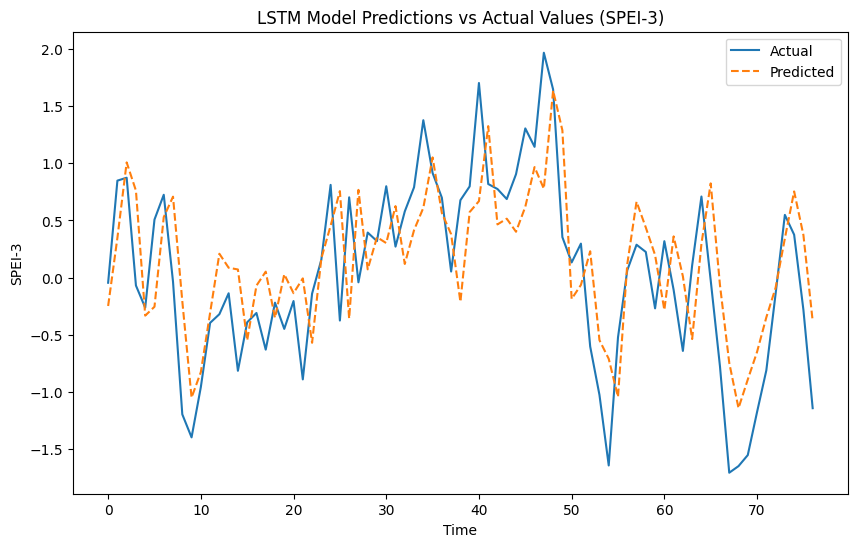

In [158]:
y_pred_spei3 = LSTM_model_spei3.predict(X_test_spei3) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei3 = scaler_spei3.inverse_transform(y_pred_spei3)
y_test_original_spei3 = scaler_spei3.inverse_transform(y_test_spei3.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei3, label="Actual")
plt.plot(y_pred_original_spei3, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-3")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-3)")
plt.show()

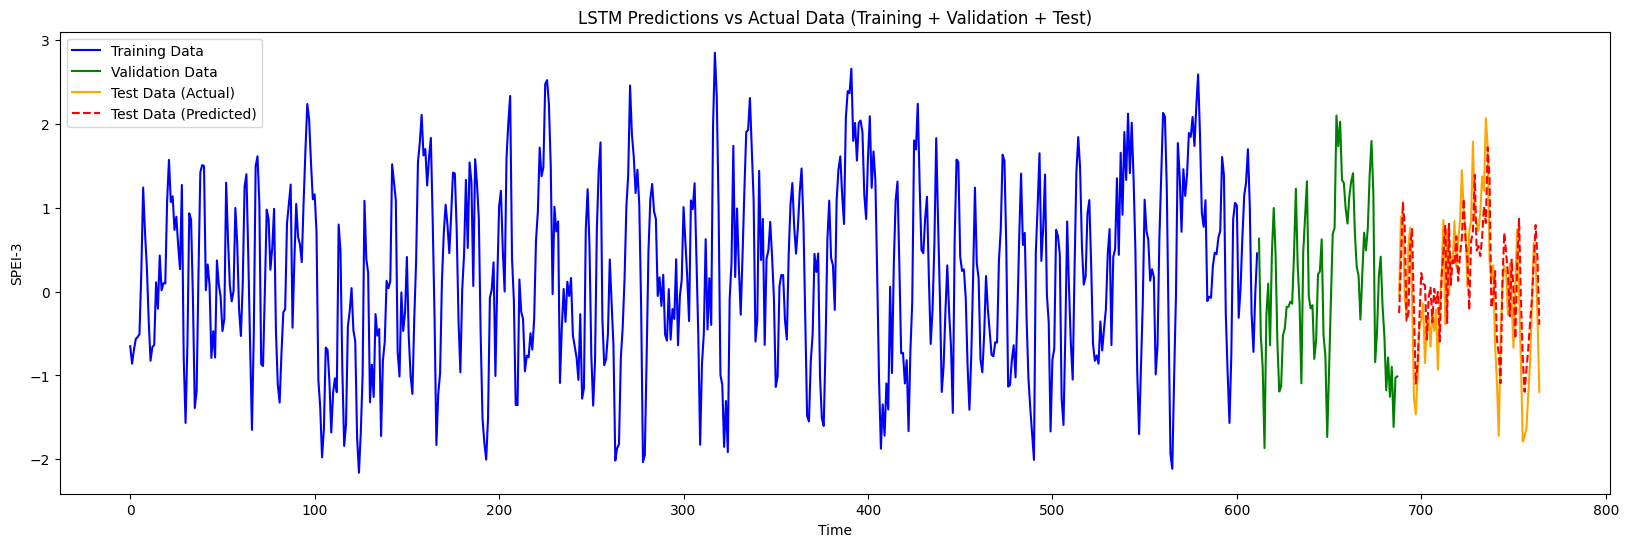

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
reversed_train_data_spei3 = scaler.inverse_transform(y_train_spei3.reshape(-1, 1))
reversed_val_data_spei3 = scaler.inverse_transform(y_val_spei3.reshape(-1, 1))
reversed_test_data_spei3 = scaler.inverse_transform(y_test_spei3.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((reversed_train_data_spei3, reversed_val_data_spei3, reversed_test_data_spei3), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(reversed_train_data_spei3, np.nan),
                                 np.full_like(reversed_val_data_spei3, np.nan),
                                 y_pred_original_spei3), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(reversed_train_data_spei3)), reversed_train_data_spei3, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(reversed_train_data_spei3), len(reversed_train_data_spei3) + len(reversed_val_data_spei3)), reversed_val_data_spei3, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(reversed_train_data_spei3) + len(reversed_val_data_spei3), len(actual_data)), reversed_test_data_spei3, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(reversed_train_data_spei3) + len(reversed_val_data_spei3), len(actual_data)), y_pred_original_spei3, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-3')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

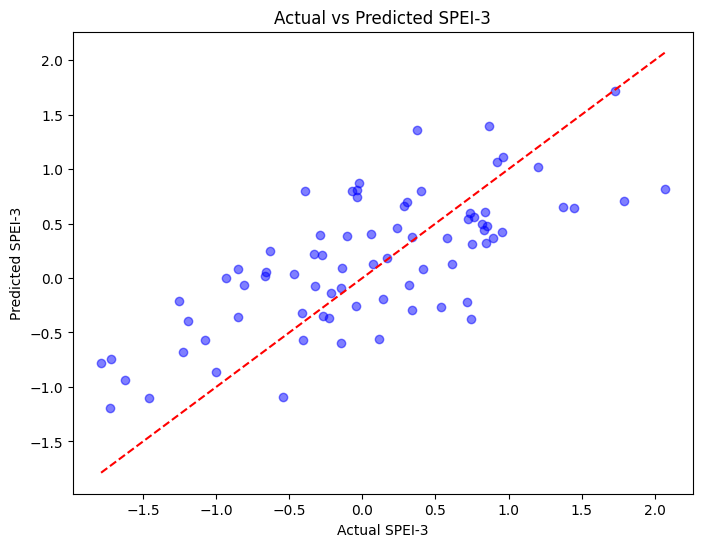

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei3, y_pred_original_spei3, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei3), max(y_test_original_spei3)], [min(y_test_original_spei3), max(y_test_original_spei3)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-3')
plt.ylabel('Predicted SPEI-3')
plt.title('Actual vs Predicted SPEI-3')
plt.show()

#### Metrics

In [ ]:
mae_spei3, mse_spei3, rmse_spei3, r2_spei3 = calculate_metrics(y_test_original_spei3, y_pred_original_spei3)
print(f"Mean Absolute Error: {mae_spei3}")
print(f"Mean Squared Error: {mse_spei3}")
print(f"Root Mean Squared Error: {rmse_spei3}")
print(f"R^2 Score: {r2_spei3}")

Mean Absolute Error: 0.5068759387276234
Mean Squared Error: 0.35902034552336926
Root Mean Squared Error: 0.5991830651173056
R^2 Score: 0.5002096165917058


In [159]:
mae_spei3, mse_spei3, rmse_spei3, r2_spei3 = calculate_metrics(y_test_original_spei3, y_pred_original_spei3)
print(f"Mean Absolute Error: {mae_spei3}")
print(f"Mean Squared Error: {mse_spei3}")
print(f"Root Mean Squared Error: {rmse_spei3}")
print(f"R^2 Score: {r2_spei3}")

Mean Absolute Error: 0.4833059999268358
Mean Squared Error: 0.32640746660361436
Root Mean Squared Error: 0.5713208088312681
R^2 Score: 0.5002096222656658


## LSTM | SPEI-6

### Model Training

In [170]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei6 = Sequential()
LSTM_model_spei6.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei6.shape[1], 1)))
LSTM_model_spei6.add(LSTM(units=64, activation='relu'))
LSTM_model_spei6.add(Dense(1))
LSTM_model_spei6.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei6 = LSTM_model_spei6.fit(X_train_spei6,
                              y_train_spei6,
                              batch_size=16,
                              validation_data=(X_val_spei6, y_val_spei6),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1448 - val_loss: 0.1131
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1167 - val_loss: 0.0853
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0895 - val_loss: 0.0646
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0677 - val_loss: 0.0891
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0663 - val_loss: 0.0614
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0644 - val_loss: 0.0552
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0549 - val_loss: 0.0550
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0542 - val_loss: 0.0524
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0515 - val_loss: 0.0516
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0503 - val_loss: 0.0509
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0494 - val_loss: 0.0504
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0488 - val_loss:

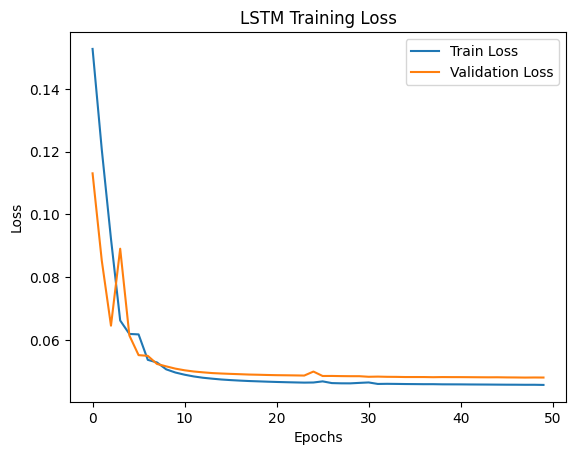

In [172]:
plt.plot(history_spei6.history['loss'], label='Train Loss')
plt.plot(history_spei6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


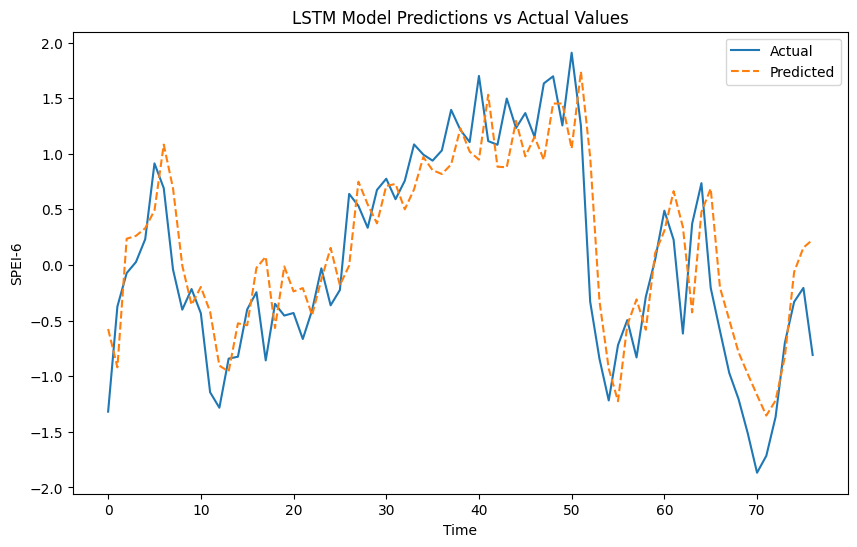

In [ ]:
y_pred_spei6 = LSTM_model_spei6.predict(X_test_spei6) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei6 = scaler_spei6.inverse_transform(y_pred_spei6)
y_test_original_spei6 = scaler_spei6.inverse_transform(y_test_spei6.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei6, label="Actual")
plt.plot(y_pred_original_spei6, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


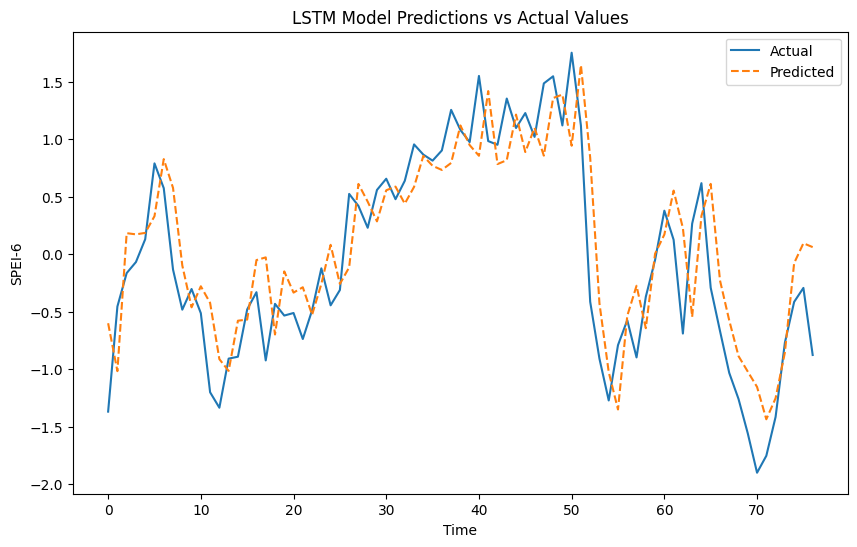

In [174]:
y_pred_spei6 = LSTM_model_spei6.predict(X_test_spei6) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei6 = scaler_spei6.inverse_transform(y_pred_spei6)
y_test_original_spei6 = scaler_spei6.inverse_transform(y_test_spei6.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei6, label="Actual")
plt.plot(y_pred_original_spei6, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

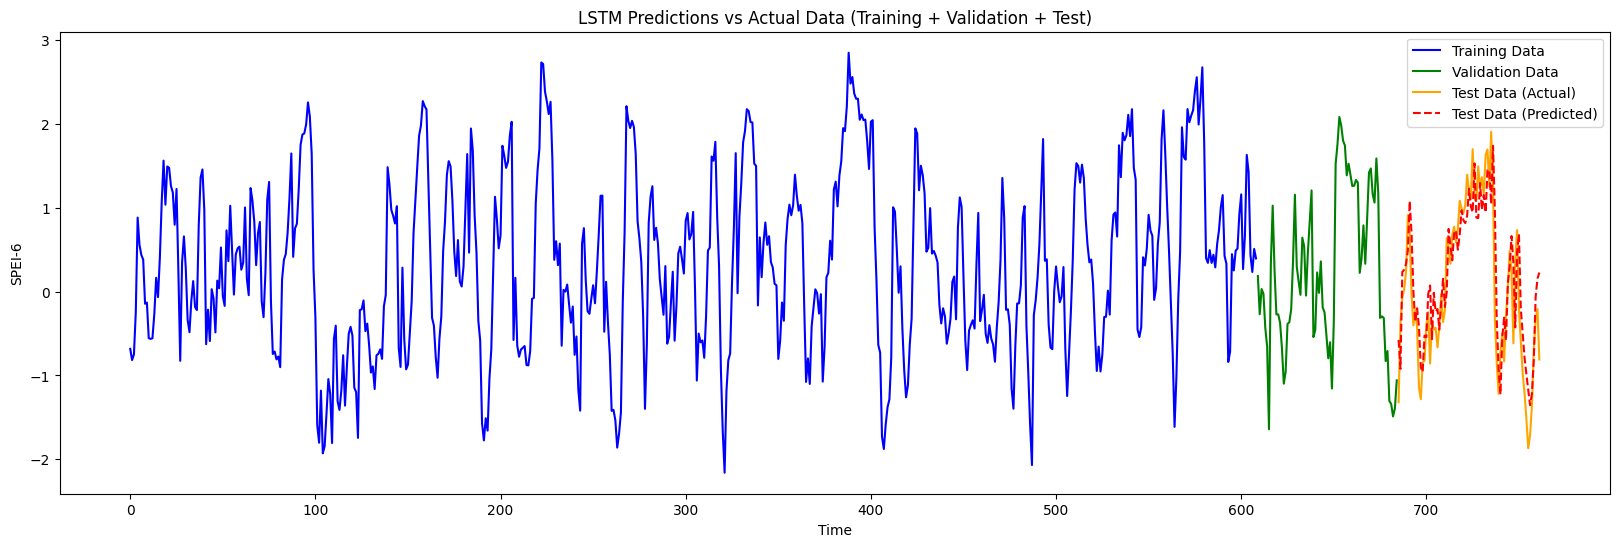

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
train_data1 = scaler.inverse_transform(y_train_spei6.reshape(-1, 1))
val_data1 = scaler.inverse_transform(y_val_spei6.reshape(-1, 1))
test_data1 = scaler.inverse_transform(y_test_spei6.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((train_data1, val_data1, test_data1), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(train_data1, np.nan),
                                 np.full_like(val_data1, np.nan),
                                 y_pred_original_spei6), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(train_data1)), train_data1, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(train_data1), len(train_data1) + len(val_data1)), val_data1, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), test_data1, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), y_pred_original_spei6, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-6')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

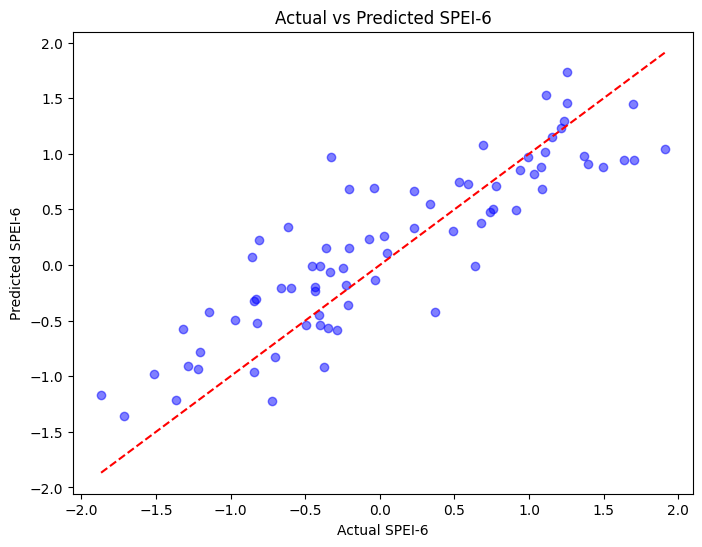

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei6, y_pred_original_spei6, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei6), max(y_test_original_spei6)], [min(y_test_original_spei6), max(y_test_original_spei6)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-6')
plt.ylabel('Predicted SPEI-6')
plt.title('Actual vs Predicted SPEI-6')
plt.show()

#### Metrics

In [176]:
mae_spei6, mse_spei6, rmse_spei6, r2_spei6 = calculate_metrics(y_test_original_spei6, y_pred_original_spei6)
print(f"Mean Absolute Error: {mae_spei6}")
print(f"Mean Squared Error: {mse_spei6}")
print(f"Root Mean Squared Error: {rmse_spei6}")
print(f"R^2 Score: {r2_spei6}")

Mean Absolute Error: 0.3714973543083179
Mean Squared Error: 0.20952656488984853
Root Mean Squared Error: 0.4577407179723566
R^2 Score: 0.738631406945825


## LSTM | SPEI-6 (TEST)

### Model Training

In [80]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei6 = Sequential()
LSTM_model_spei6.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
LSTM_model_spei6.add(LSTM(units=64, activation='relu'))
LSTM_model_spei6.add(Dense(1))
LSTM_model_spei6.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei6 = LSTM_model_spei6.fit(X_train,
                              y_train,
                              batch_size=16,
                              validation_data=(X_val, y_val),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1448 - val_loss: 0.1131
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1167 - val_loss: 0.0853
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0895 - val_loss: 0.0646
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0677 - val_loss: 0.0891
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0663 - val_loss: 0.0614
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0644 - val_loss: 0.0552
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0549 - val_loss: 0.0550
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0542 - val_loss: 0.0524
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0515 - val_loss: 0.0516
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0503 - val_loss: 0.0509
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0494 - val_loss: 0.0504
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0488 -

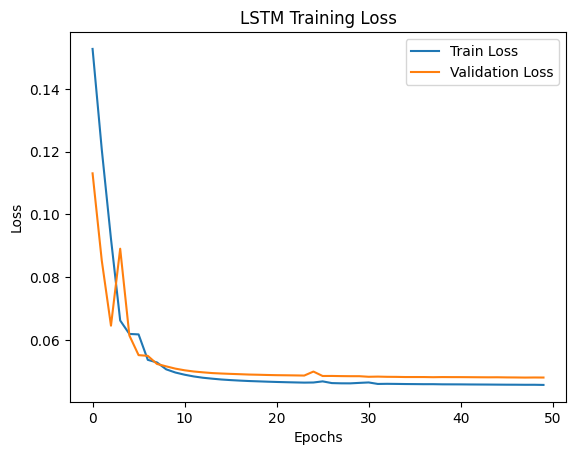

In [75]:
plt.plot(history_spei6.history['loss'], label='Train Loss')
plt.plot(history_spei6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

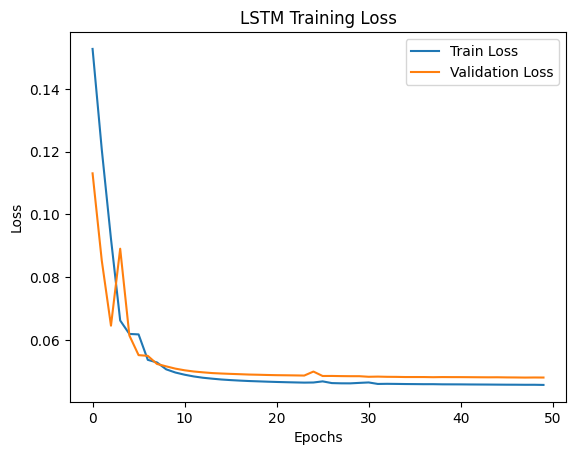

In [81]:
plt.plot(history_spei6.history['loss'], label='Train Loss')
plt.plot(history_spei6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


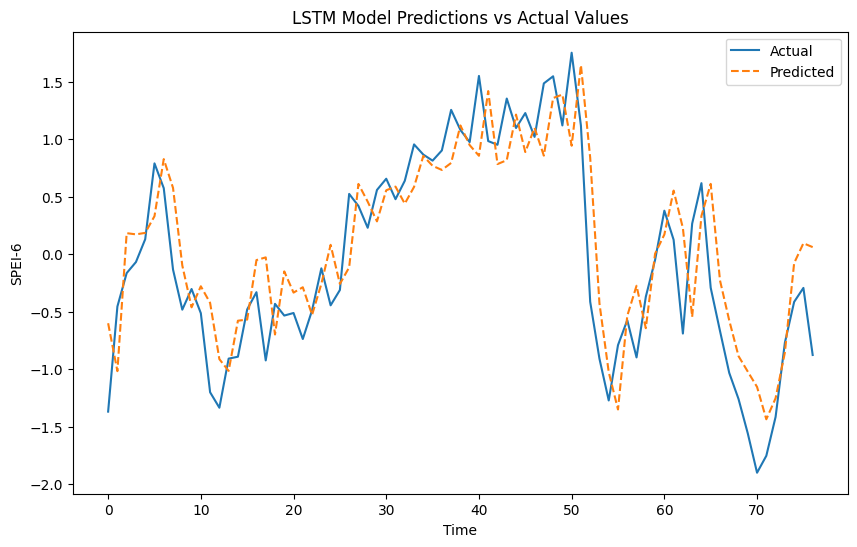

In [83]:
y_pred = LSTM_model_spei6.predict(X_test) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original = scaler_spei6.inverse_transform(y_pred)
y_test_original = scaler_spei6.inverse_transform(y_test.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred_original, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

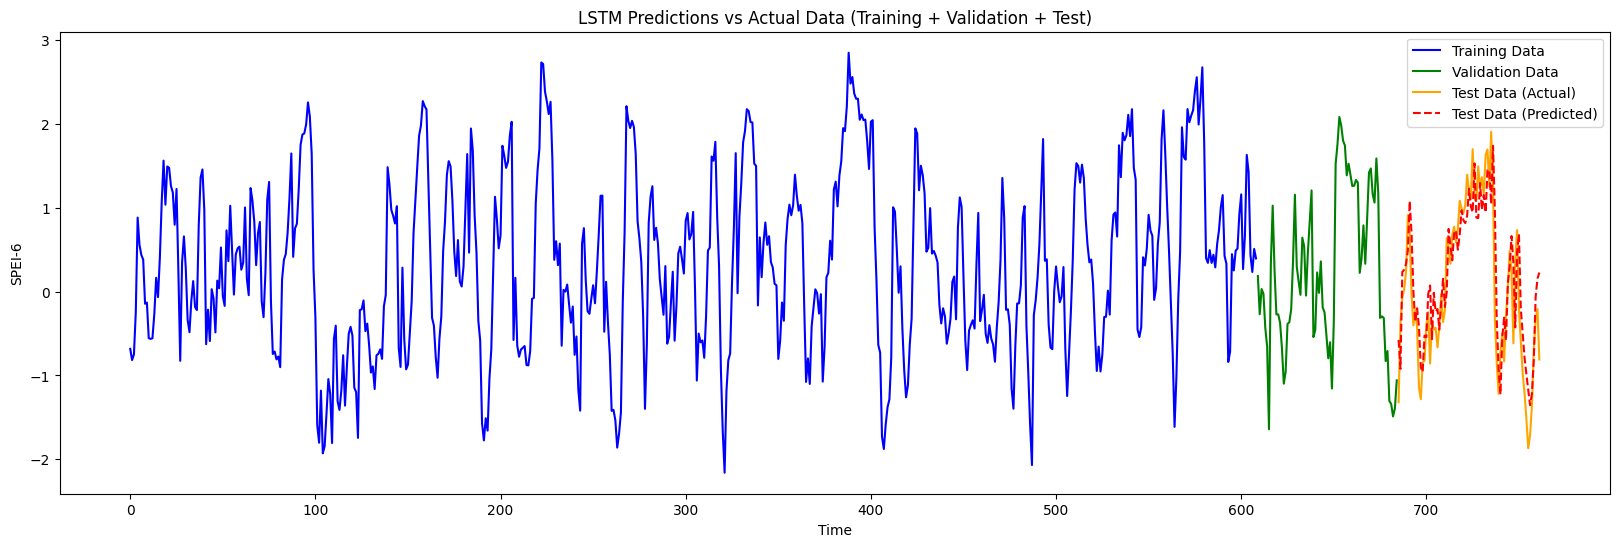

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
train_data1 = scaler.inverse_transform(y_train_spei6.reshape(-1, 1))
val_data1 = scaler.inverse_transform(y_val_spei6.reshape(-1, 1))
test_data1 = scaler.inverse_transform(y_test_spei6.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((train_data1, val_data1, test_data1), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(train_data1, np.nan),
                                 np.full_like(val_data1, np.nan),
                                 y_pred_original_spei6), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(train_data1)), train_data1, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(train_data1), len(train_data1) + len(val_data1)), val_data1, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), test_data1, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), y_pred_original_spei6, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-6')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

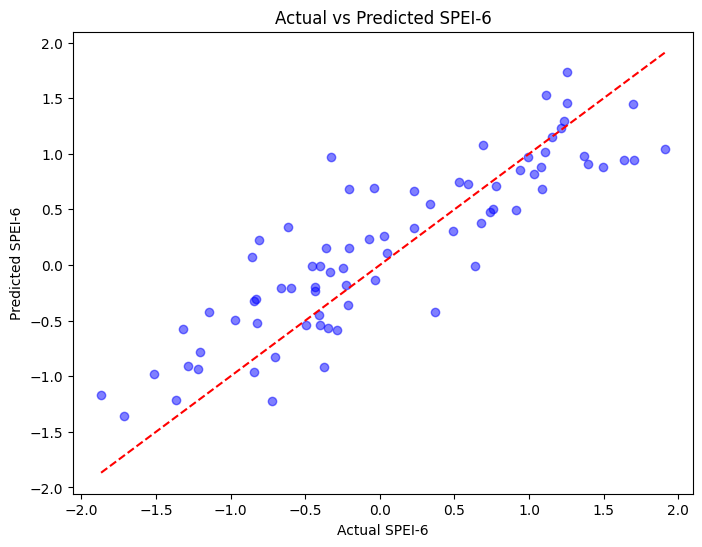

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei6, y_pred_original_spei6, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei6), max(y_test_original_spei6)], [min(y_test_original_spei6), max(y_test_original_spei6)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-6')
plt.ylabel('Predicted SPEI-6')
plt.title('Actual vs Predicted SPEI-6')
plt.show()

#### Metrics

In [ ]:
mae_spei6, mse_spei6, rmse_spei6, r2_spei6 = calculate_metrics(y_test_original_spei6, y_pred_original_spei6)
print(f"Mean Absolute Error: {mae_spei6}")
print(f"Mean Squared Error: {mse_spei6}")
print(f"Root Mean Squared Error: {rmse_spei6}")
print(f"R^2 Score: {r2_spei6}")

Mean Absolute Error: 0.3769804553549269
Mean Squared Error: 0.21672900984964086
Root Mean Squared Error: 0.4655416306300016
R^2 Score: 0.7470627017320879


In [78]:
mae_spei6, mse_spei6, rmse_spei6, r2_spei6 = calculate_metrics(y_test_original, y_pred_original)  #NOTES: this was after scaling only the training data
print(f"Mean Absolute Error: {mae_spei6}")
print(f"Mean Squared Error: {mse_spei6}")
print(f"Root Mean Squared Error: {rmse_spei6}")
print(f"R^2 Score: {r2_spei6}")

Mean Absolute Error: 0.3714973543083179
Mean Squared Error: 0.20952656488984853
Root Mean Squared Error: 0.4577407179723566
R^2 Score: 0.738631406945825


In [84]:
mae_spei6, mse_spei6, rmse_spei6, r2_spei6 = calculate_metrics(y_test_original, y_pred_original)  #NOTES: this was after scaling only the training data
print(f"Mean Absolute Error: {mae_spei6}")
print(f"Mean Squared Error: {mse_spei6}")
print(f"Root Mean Squared Error: {rmse_spei6}")
print(f"R^2 Score: {r2_spei6}")

Mean Absolute Error: 0.3714973543083179
Mean Squared Error: 0.20952656488984853
Root Mean Squared Error: 0.4577407179723566
R^2 Score: 0.738631406945825


## LSTM | SPEI-12

### Model Training

In [177]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei12 = Sequential()
LSTM_model_spei12.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei12.shape[1], 1)))
LSTM_model_spei12.add(LSTM(units=64, activation='relu'))
LSTM_model_spei12.add(Dense(1))
LSTM_model_spei12.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei12 = LSTM_model_spei12.fit(X_train_spei12,
                                      y_train_spei12,
                                      batch_size=16,
                                      validation_data=(X_val_spei12, y_val_spei12),
                                      epochs=50,
                                      verbose=1, # just determines how much info to display for each epoch
                                      shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1281 - val_loss: 0.0786
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0865 - val_loss: 0.0530
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0598 - val_loss: 0.0427
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0501 - val_loss: 0.0371
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0431 - val_loss: 0.0416
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0455 - val_loss: 0.0331
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0367 - val_loss: 0.0251
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0272 - val_loss: 0.0238
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0272 - val_loss: 0.0215
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0260 - val_loss: 0.0275
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0274 - val_l

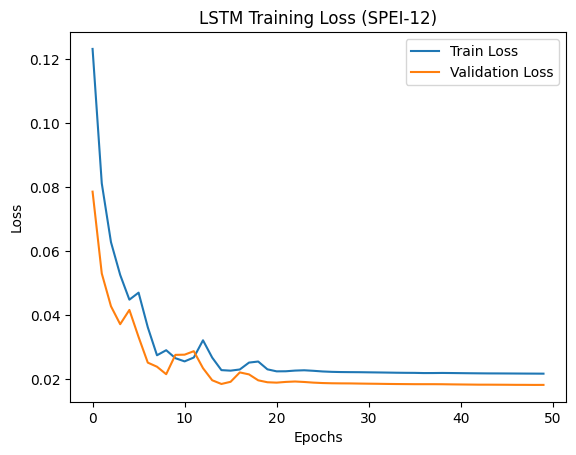

In [ ]:
plt.plot(history_spei12.history['loss'], label='Train Loss')
plt.plot(history_spei12.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss (SPEI-12)')
plt.show()

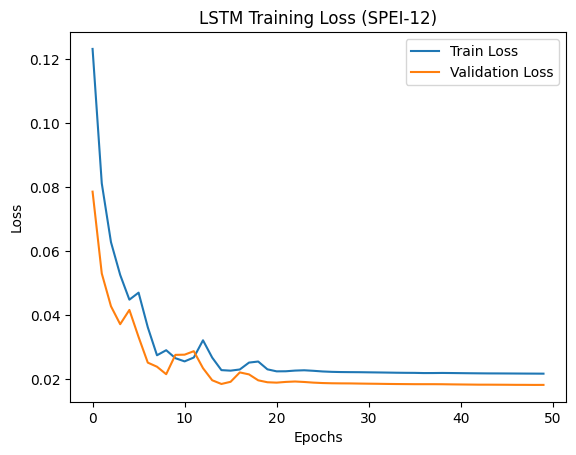

In [178]:
plt.plot(history_spei12.history['loss'], label='Train Loss')
plt.plot(history_spei12.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss (SPEI-12)')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


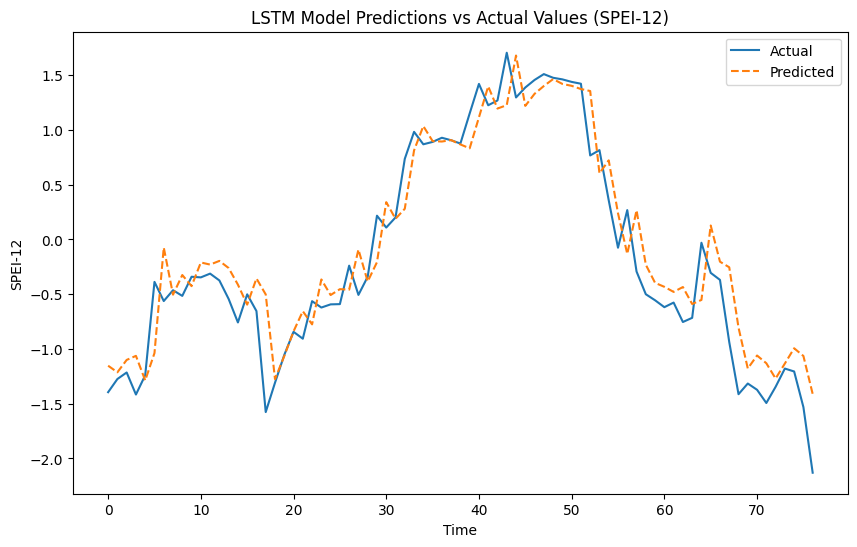

In [ ]:
y_pred_spei12 = LSTM_model_spei12.predict(X_test_spei12) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei12 = scaler_spei12.inverse_transform(y_pred_spei12)
y_test_original_spei12 = scaler_spei12.inverse_transform(y_test_spei12.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei12, label="Actual")
plt.plot(y_pred_original_spei12, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-12")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-12)")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


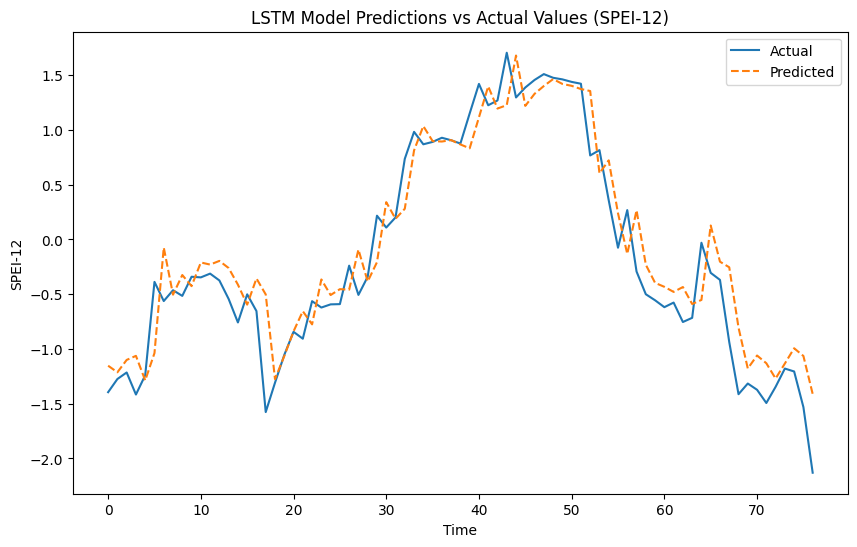

In [179]:
y_pred_spei12 = LSTM_model_spei12.predict(X_test_spei12) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei12 = scaler_spei12.inverse_transform(y_pred_spei12)
y_test_original_spei12 = scaler_spei12.inverse_transform(y_test_spei12.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei12, label="Actual")
plt.plot(y_pred_original_spei12, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-12")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-12)")
plt.show()

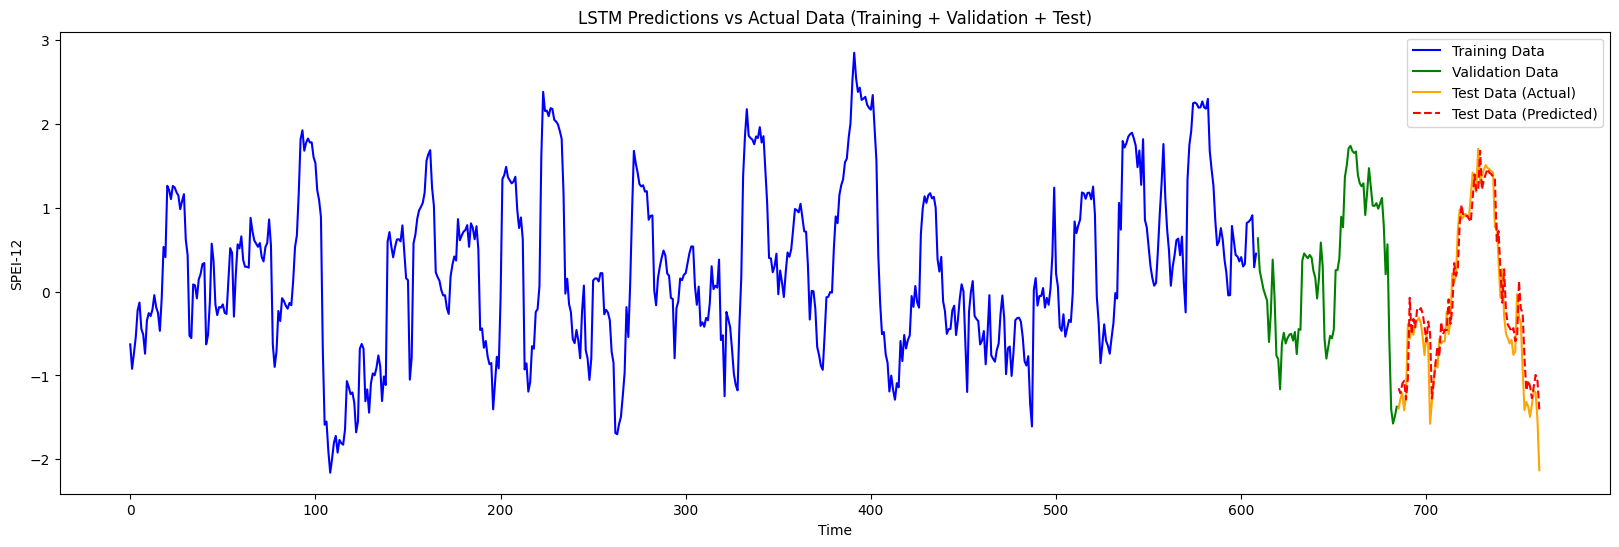

In [182]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
normal_train_data_spei12 = scaler_spei12.inverse_transform(y_train_spei12.reshape(-1, 1))
normal_val_data_spei12 = scaler_spei12.inverse_transform(y_val_spei12.reshape(-1, 1))
normal_test_data_spei12 = scaler_spei12.inverse_transform(y_test_spei12.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data_spei12 = np.concatenate((normal_train_data_spei12, normal_val_data_spei12, normal_test_data_spei12), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data_spei12 = np.concatenate((np.full_like(normal_train_data_spei12, np.nan),
                                 np.full_like(normal_val_data_spei12, np.nan),
                                 y_pred_original_spei12), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(normal_train_data_spei12)), normal_train_data_spei12, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(normal_train_data_spei12), len(normal_train_data_spei12) + len(normal_val_data_spei12)), normal_val_data_spei12, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(normal_train_data_spei12) + len(normal_val_data_spei12), len(actual_data)), normal_test_data_spei12, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(normal_train_data_spei12) + len(normal_val_data_spei12), len(actual_data)), y_pred_original_spei12, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-12')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

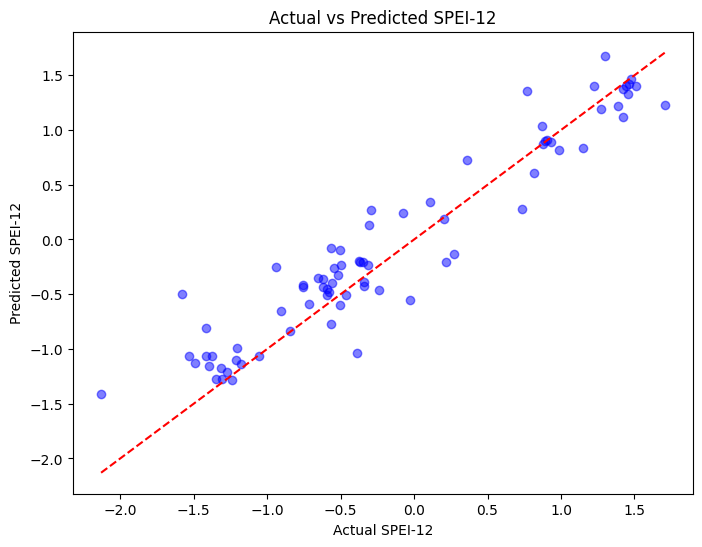

In [184]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei12, y_pred_original_spei12, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei12), max(y_test_original_spei12)], [min(y_test_original_spei12), max(y_test_original_spei12)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-12')
plt.ylabel('Predicted SPEI-12')
plt.title('Actual vs Predicted SPEI-12')
plt.show()

#### Metrics

In [186]:
mae_spei12, mse_spei12, rmse_spei12, r2_spei12 = calculate_metrics(y_test_original_spei12, y_pred_original_spei12)
print(f"Mean Absolute Error: {mae_spei12}")
print(f"Mean Squared Error: {mse_spei12}")
print(f"Root Mean Squared Error: {rmse_spei12}")
print(f"R^2 Score: {r2_spei12}")

Mean Absolute Error: 0.24105272799614816
Mean Squared Error: 0.10033336910443741
Root Mean Squared Error: 0.3167544302838358
R^2 Score: 0.8953437457159582


# Extended Data (1950-2023)

## Data Preprocessing

In [188]:
# graph data
def graph_spei_data(data, timescale):
  plt.figure(figsize=(24, 7))
  plt.plot(data['spei'], c='cyan')
  title = f"SPEI on {timescale}-Month Timescale"
  plt.title(title)
  plt.xlabel("Date")
  plt.ylabel(f"SPEI-{timescale}")
  plt.figure(figsize=(18, 6))
  plt.show()

In [187]:
def create_samples(data, time_steps=12):
  X, y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps)])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

In [189]:
def normalize_data(X_train, y_train, X_val, y_val, X_test, y_test):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_train_flat = X_train.reshape(-1, 1)
  scaler.fit(X_train_flat)    # fit scaler on training data only

  # transform train data
  X_train_scaled = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
  y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()

  # transform val data
  X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
  y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()

  # transform test data
  X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
  y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

  return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, scaler

### SPEI-1

In [191]:
# load data
spei1_df = pd.read_csv('/content/SPEI_1_MonthTimescale_1950_2023_Fresno.csv')
spei1_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75  0.568691
1  1950-02-15 -119.75  36.75 -0.323044
2  1950-03-16 -119.75  36.75 -0.148050
3  1950-04-16 -119.75  36.75 -0.585959
4  1950-05-16 -119.75  36.75 -0.860067

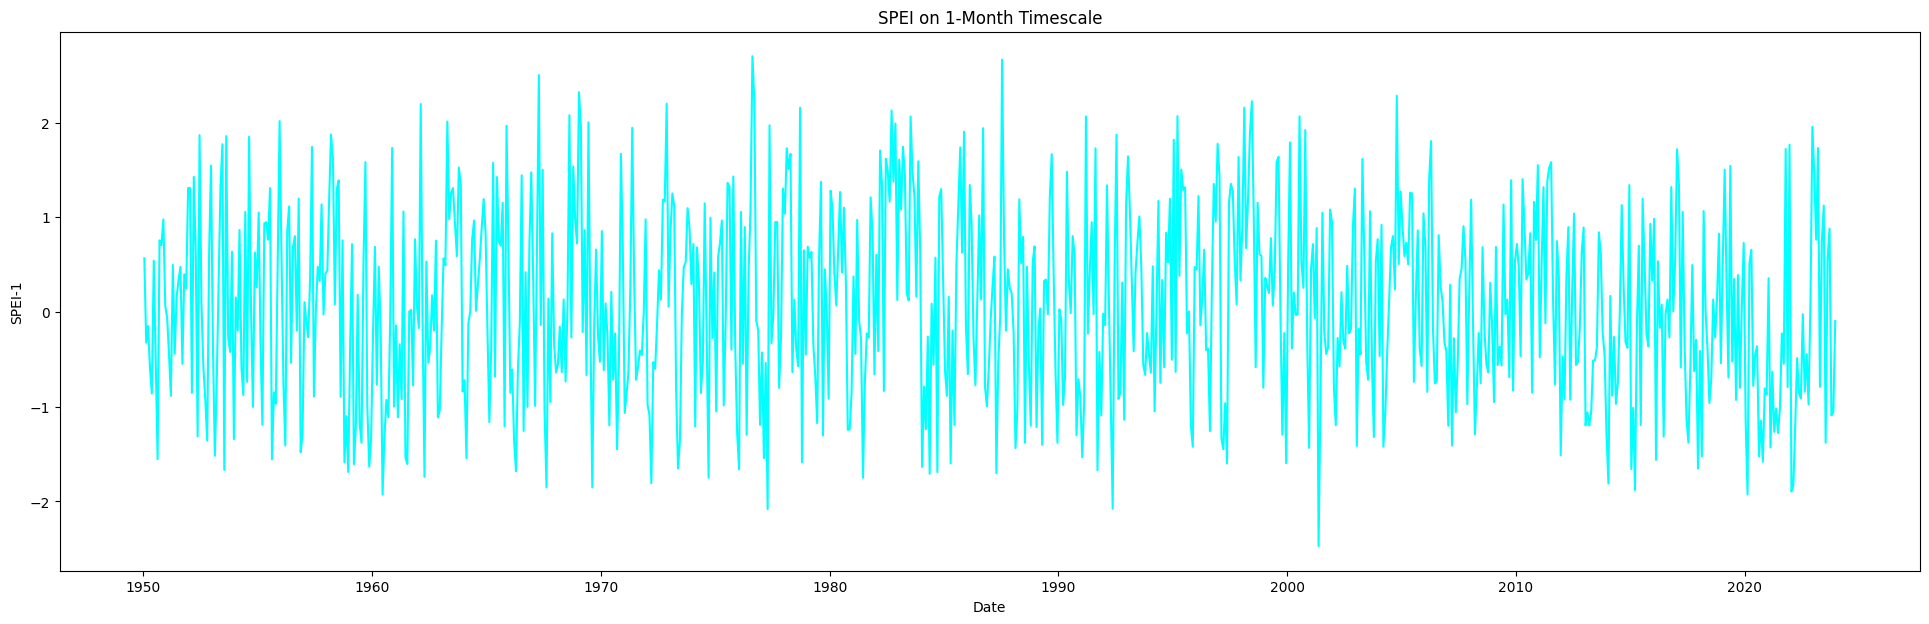

<Figure size 1800x600 with 0 Axes>

In [192]:
spei1_df['time'] = pd.to_datetime(spei1_df['time'], format='%Y-%m-%d')
spei1_df.set_index('time', inplace=True)
graph_spei_data(spei1_df, 1)

In [193]:
# --- split into train/val/test --- #

# get data samples
time_steps = 6
X_spei1, y_spei1 = create_samples(spei1_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei1 = X_spei1.reshape((X_spei1.shape[0], X_spei1.shape[1], 1))

# get splits
train_size = int(len(X_spei1) * 0.8)
val_size = int(len(X_spei1) * 0.1)

X_train_spei1, y_train_spei1 = X_spei1[:train_size], y_spei1[:train_size]
X_val_spei1, y_val_spei1 = X_spei1[train_size:train_size + val_size], y_spei1[train_size:train_size + val_size]
X_test_spei1, y_test_spei1 = X_spei1[train_size + val_size:], y_spei1[train_size + val_size:]

print(f"Training splits (80%):  X_train_spei1 = {X_train_spei1.shape} | y_train_spei1 = {y_train_spei1.shape}")
print(f"Validation splits (10%):  X_val_spei1 = {X_val_spei1.shape} | y_val_spei1 = {y_val_spei1.shape}")
print(f"Test splits (10%):  X_test_spei1 = {X_test_spei1.shape} | y_test_spei1 = {y_test_spei1.shape}")

Training splits (80%):  X_train_spei1 = (705, 6, 1) | y_train_spei1 = (705,)
Validation splits (10%):  X_val_spei1 = (88, 6, 1) | y_val_spei1 = (88,)
Test splits (10%):  X_test_spei1 = (89, 6, 1) | y_test_spei1 = (89,)


In [194]:
# normalize data
X_train_spei1, y_train_spei1, X_val_spei1, y_val_spei1, X_test_spei1, y_test_spei1, scaler_spei1 = normalize_data(X_train_spei1,
                                                                                                                  y_train_spei1,
                                                                                                                  X_val_spei1,
                                                                                                                  y_val_spei1,
                                                                                                                  X_test_spei1,
                                                                                                                  y_test_spei1)

In [195]:
X_train_spei1[0], y_train_spei1[0]  # example sample

(array([[ 0.17565142],
        [-0.16910384],
        [-0.10144917],
        [-0.2707497 ],
        [-0.37672339],
        [ 0.16538455]]),
 np.float64(-0.24177723183042663))

### SPEI-1

In [ ]:
# load data
spei1_df = pd.read_csv('/content/SPEI_1_MonthTimescale_1950_2023_Fresno.csv')
spei1_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75  0.568691
1  1950-02-15 -119.75  36.75 -0.323044
2  1950-03-16 -119.75  36.75 -0.148050
3  1950-04-16 -119.75  36.75 -0.585959
4  1950-05-16 -119.75  36.75 -0.860067

In [ ]:
spei1_df.isnull().sum()

time    0
lon     0
lat     0
spei    0
dtype: int64

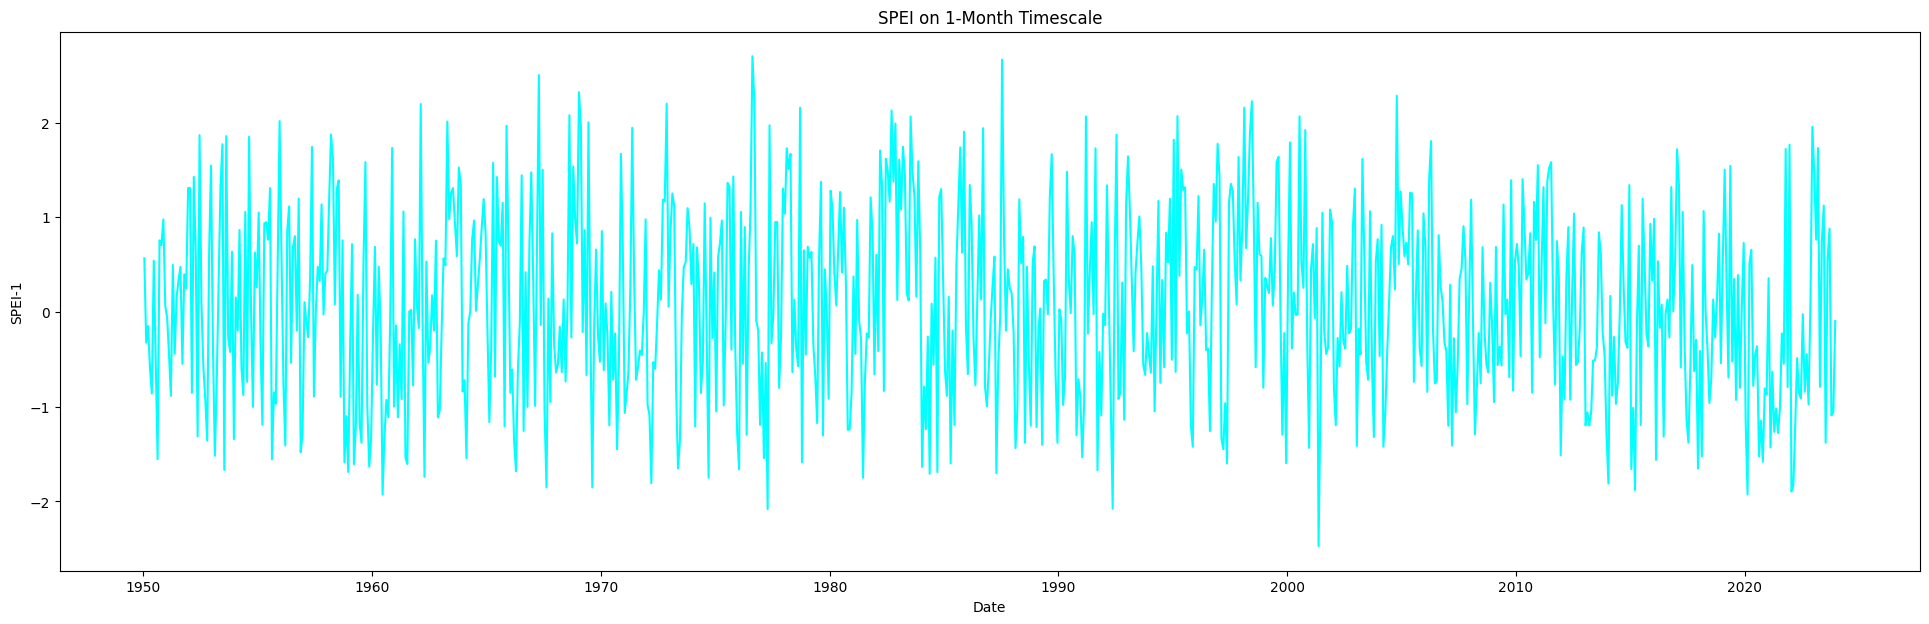

<Figure size 1800x600 with 0 Axes>

In [ ]:
spei1_df['time'] = pd.to_datetime(spei1_df['time'], format='%Y-%m-%d')
spei1_df.set_index('time', inplace=True)
graph_spei_data(spei1_df, 1)

In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
spei1_df['spei'] = scaler.fit_transform(spei1_df[['spei']])
spei1_df.head(5)

lon    lat      spei
time                               
1950-01-16 -119.75  36.75  0.175651
1950-02-15 -119.75  36.75 -0.169104
1950-03-16 -119.75  36.75 -0.101449
1950-04-16 -119.75  36.75 -0.270750
1950-05-16 -119.75  36.75 -0.376723

In [ ]:
# get data samples
time_steps = 6
X_spei1, y_spei1 = create_samples(spei1_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei1 = X_spei1.reshape((X_spei1.shape[0], X_spei1.shape[1], 1))
print(X_spei1.shape)
print(y_spei1.shape)

for i in range(len(X_spei1)):
  if (i == 2):
    break
  print(X_spei1[i], y_spei1[i])

(882, 6, 1)
(882,)
[[ 0.17565142]
 [-0.16910384]
 [-0.10144917]
 [-0.2707497 ]
 [-0.37672339]
 [ 0.16538455]] -0.24177723183042663
[[-0.16910384]
 [-0.10144917]
 [-0.2707497 ]
 [-0.37672339]
 [ 0.16538455]
 [-0.24177723]] -0.6447199929543874


In [ ]:
train_size = int(len(X_spei1) * 0.8)
val_size = int(len(X_spei1) * 0.1)

X_train_spei1, y_train_spei1 = X_spei1[:train_size], y_spei1[:train_size]
X_val_spei1, y_val_spei1 = X_spei1[train_size : train_size + val_size], y_spei1[train_size : train_size + val_size]
X_test_spei1, y_test_spei1 = X_spei1[train_size + val_size :], y_spei1[train_size + val_size :]


print(f"Training splits (80%):  X_train = {X_train_spei1.shape} | y_train = {y_train_spei1.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei1.shape} | y_val = {y_val_spei1.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei1.shape} | y_test = {y_test_spei1.shape}")

Training splits (80%):  X_train = (705, 6, 1) | y_train = (705,)
Validation splits (10%):  X_val = (88, 6, 1) | y_val = (88,)
Test splits (10%):  X_test = (89, 6, 1) | y_test = (89,)


In [ ]:
X_train_spei1[0], y_train_spei1[0]  # example sample

(array([[ 0.17565142],
        [-0.16910384],
        [-0.10144917],
        [-0.2707497 ],
        [-0.37672339],
        [ 0.16538455]]),
 np.float64(-0.24177723183042663))

In [ ]:
y_test_spei1.max(), y_test_spei1.min()

(np.float64(0.7115599080822811), np.float64(-0.7883224459596018))

### SPEI-3

In [ ]:
# load data
spei3_df = pd.read_csv('/content/SPEI_3_MonthTimescale_1950_2023_Fresno.csv')
spei3_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75 -0.113825
1  1950-02-15 -119.75  36.75 -0.082312
2  1950-03-16 -119.75  36.75 -0.025755
3  1950-04-16 -119.75  36.75 -0.624708
4  1950-05-16 -119.75  36.75 -0.823265

In [ ]:
spei3_df.isnull().sum()

time    0
lon     0
lat     0
spei    0
dtype: int64

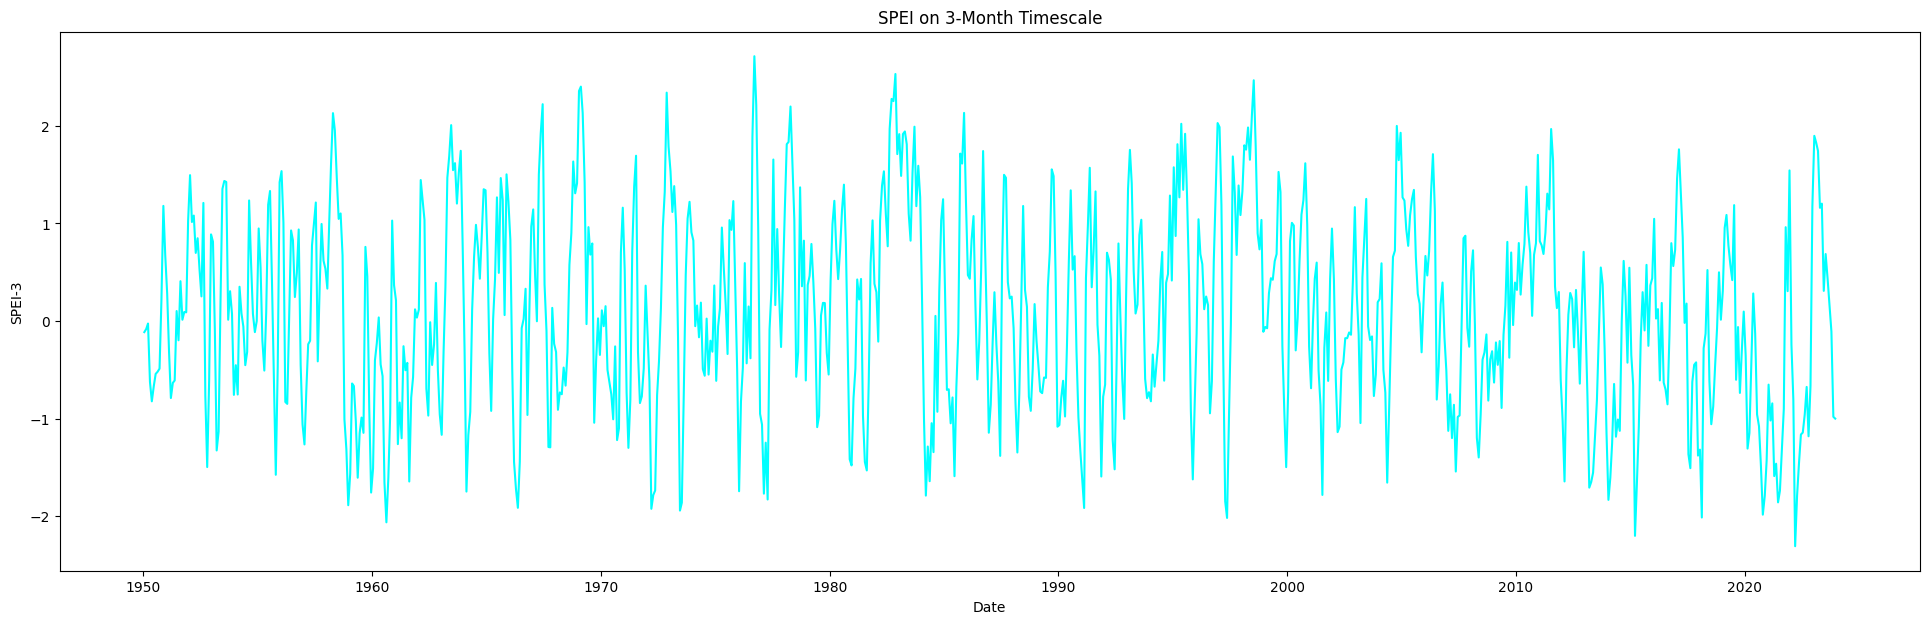

<Figure size 1800x600 with 0 Axes>

In [ ]:
spei3_df['time'] = pd.to_datetime(spei3_df['time'], format='%Y-%m-%d')
spei3_df.set_index('time', inplace=True)
graph_spei_data(spei3_df, 3)

In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
spei3_df['spei'] = scaler.fit_transform(spei3_df[['spei']])
spei3_df.head(5)

lon    lat      spei
time                               
1950-01-16 -119.75  36.75 -0.126118
1950-02-15 -119.75  36.75 -0.113572
1950-03-16 -119.75  36.75 -0.091055
1950-04-16 -119.75  36.75 -0.329519
1950-05-16 -119.75  36.75 -0.408571

In [ ]:
# get data samples
time_steps = 3
X_spei3, y_spei3 = create_samples(spei3_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei3 = X_spei3.reshape((X_spei3.shape[0], X_spei3.shape[1], 1))
print(X_spei3.shape)
print(y_spei3.shape)

for i in range(len(X_spei3)):
  if (i == 2):
    break
  print(X_spei3[i], y_spei3[i])

(885, 3, 1)
(885,)
[[-0.12611827]
 [-0.11357193]
 [-0.09105475]] -0.3295185634701666
[[-0.11357193]
 [-0.09105475]
 [-0.32951856]] -0.40857132397568885


In [ ]:
train_size = int(len(X_spei3) * 0.8)
val_size = int(len(X_spei3) * 0.1)

X_train_spei3, y_train_spei3 = X_spei3[:train_size], y_spei3[:train_size]
X_val_spei3, y_val_spei3 = X_spei3[train_size : train_size + val_size], y_spei3[train_size : train_size + val_size]
X_test_spei3, y_test_spei3 = X_spei3[train_size + val_size :], y_spei3[train_size + val_size :]


print(f"Training splits (80%):  X_train = {X_train_spei3.shape} | y_train = {y_train_spei3.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei3.shape} | y_val = {y_val_spei3.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei3.shape} | y_test = {y_test_spei3.shape}")

Training splits (80%):  X_train = (708, 3, 1) | y_train = (708,)
Validation splits (10%):  X_val = (88, 3, 1) | y_val = (88,)
Test splits (10%):  X_test = (89, 3, 1) | y_test = (89,)


In [ ]:
X_train_spei3[0], y_train_spei3[0]  # example sample

(array([[-0.12611827],
        [-0.11357193],
        [-0.09105475]]),
 np.float64(-0.3295185634701666))

In [ ]:
y_test_spei3.max(), y_test_spei3.min()

(np.float64(0.6749549007655596), np.float64(-1.0))

### SPEI-6

In [ ]:
# load data
spei6_df = pd.read_csv('/content/SPEI_6_MonthTimescale_1950_2023_Fresno.csv')
spei6_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75 -0.177393
1  1950-02-15 -119.75  36.75 -0.520186
2  1950-03-16 -119.75  36.75 -0.425508
3  1950-04-16 -119.75  36.75 -0.482449
4  1950-05-16 -119.75  36.75 -0.595851

In [ ]:
spei6_df.isnull().sum()

time    0
lon     0
lat     0
spei    0
dtype: int64

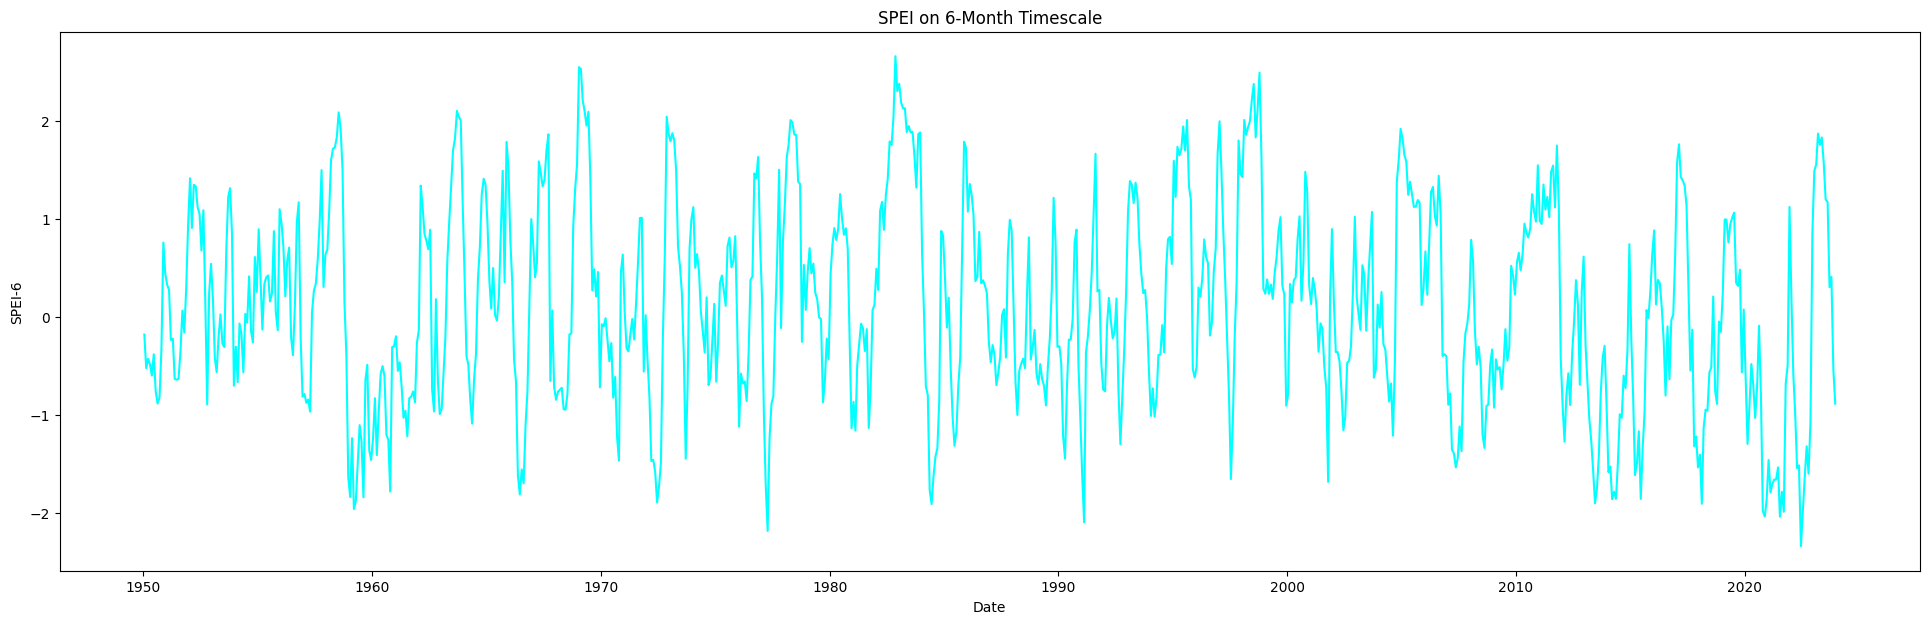

<Figure size 1800x600 with 0 Axes>

In [ ]:
spei6_df['time'] = pd.to_datetime(spei6_df['time'], format='%Y-%m-%d')
spei6_df.set_index('time', inplace=True)
graph_spei_data(spei6_df, 6)

In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
spei6_df['spei'] = scaler.fit_transform(spei6_df[['spei']])
spei6_df.head(5)

lon    lat      spei
time                               
1950-01-16 -119.75  36.75 -0.135829
1950-02-15 -119.75  36.75 -0.272857
1950-03-16 -119.75  36.75 -0.235010
1950-04-16 -119.75  36.75 -0.257772
1950-05-16 -119.75  36.75 -0.303103

In [ ]:
# get data samples
time_steps = 6
X_spei6, y_spei6 = create_samples(spei6_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei6 = X_spei6.reshape((X_spei6.shape[0], X_spei6.shape[1], 1))
print(X_spei6.shape)
print(y_spei6.shape)

for i in range(len(X_spei6)):
  if (i == 2):
    break
  print(X_spei6[i], y_spei6[i])

(882, 6, 1)
(882,)
[[-0.13582876]
 [-0.27285721]
 [-0.23501047]
 [-0.25777222]
 [-0.30310327]
 [-0.21661964]] -0.3660802596201403
[[-0.27285721]
 [-0.23501047]
 [-0.25777222]
 [-0.30310327]
 [-0.21661964]
 [-0.36608026]] -0.4179318387602677


In [ ]:
train_size = int(len(X_spei6) * 0.8)
val_size = int(len(X_spei6) * 0.1)

X_train_spei6, y_train_spei6 = X_spei6[:train_size], y_spei6[:train_size]
X_val_spei6, y_val_spei6 = X_spei6[train_size : train_size + val_size], y_spei6[train_size : train_size + val_size]
X_test_spei6, y_test_spei6 = X_spei6[train_size + val_size :], y_spei6[train_size + val_size :]


print(f"Training splits (80%):  X_train = {X_train_spei6.shape} | y_train = {y_train_spei6.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei6.shape} | y_val = {y_val_spei6.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei6.shape} | y_test = {y_test_spei6.shape}")

Training splits (80%):  X_train = (705, 6, 1) | y_train = (705,)
Validation splits (10%):  X_val = (88, 6, 1) | y_val = (88,)
Test splits (10%):  X_test = (89, 6, 1) | y_test = (89,)


In [ ]:
X_train_spei6[0], y_train_spei6[0]  # example sample

(array([[-0.13582876],
        [-0.27285721],
        [-0.23501047],
        [-0.25777222],
        [-0.30310327],
        [-0.21661964]]),
 np.float64(-0.3660802596201403))

In [ ]:
y_test_spei6.max(), y_test_spei6.min()

(np.float64(0.6845119536544282), np.float64(-1.0))

### SPEI-12

In [ ]:
# load data
spei12_df = pd.read_csv('/content/SPEI_12_MonthTimescale_1950_2023_Fresno.csv')
spei12_df.head(5)

time     lon    lat      spei
0  1950-01-16 -119.75  36.75 -0.291648
1  1950-02-15 -119.75  36.75 -0.343679
2  1950-03-16 -119.75  36.75 -0.756500
3  1950-04-16 -119.75  36.75 -0.402883
4  1950-05-16 -119.75  36.75 -0.857081

In [ ]:
spei12_df.isnull().sum()

time    0
lon     0
lat     0
spei    0
dtype: int64

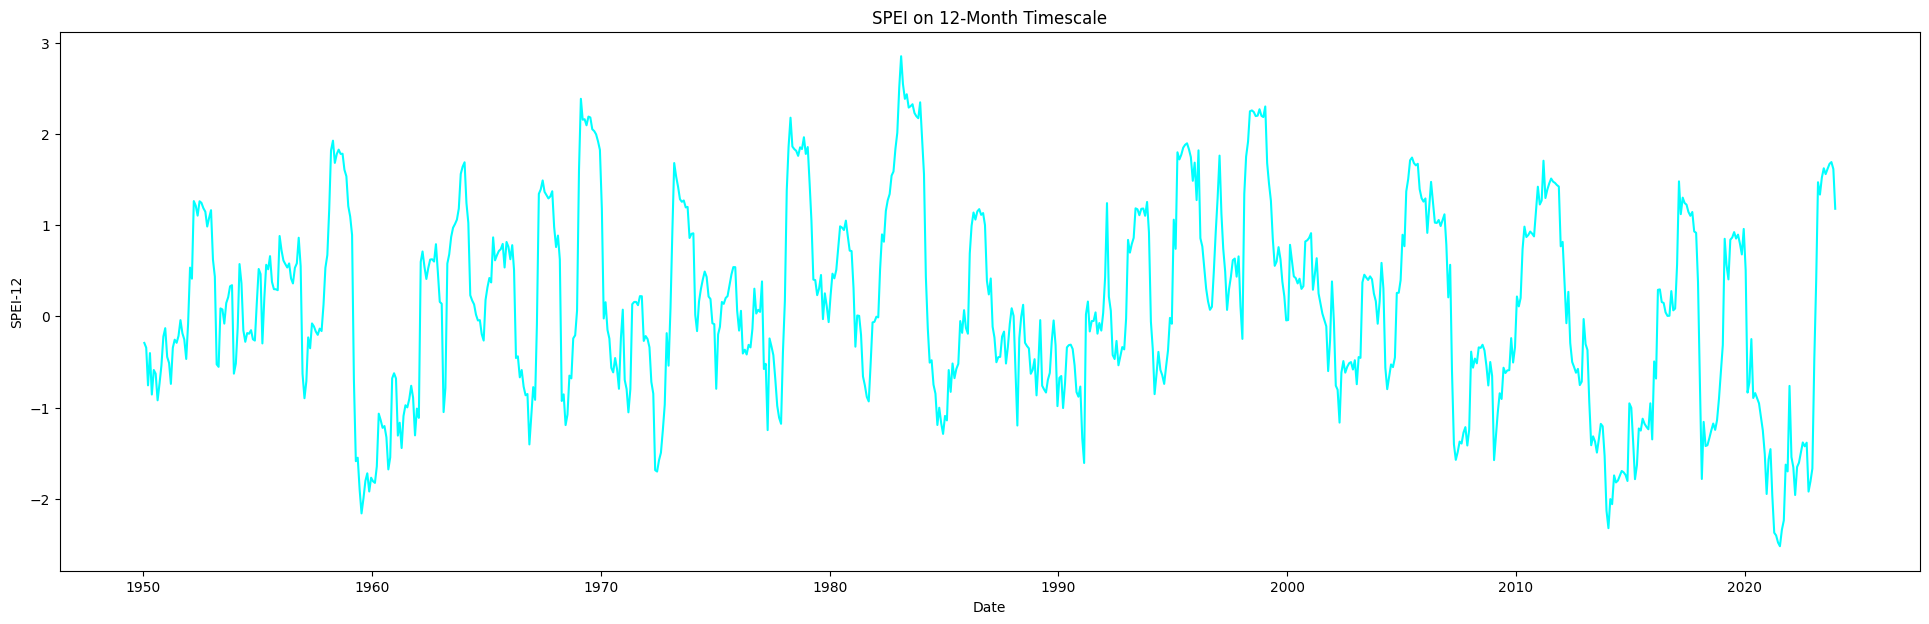

<Figure size 1800x600 with 0 Axes>

In [ ]:
spei12_df['time'] = pd.to_datetime(spei12_df['time'], format='%Y-%m-%d')
spei12_df.set_index('time', inplace=True)
graph_spei_data(spei12_df, 12)

In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
spei12_df['spei'] = scaler.fit_transform(spei12_df[['spei']])
spei12_df.head(5)

lon    lat      spei
time                               
1950-01-16 -119.75  36.75 -0.170265
1950-02-15 -119.75  36.75 -0.189639
1950-03-16 -119.75  36.75 -0.343356
1950-04-16 -119.75  36.75 -0.211684
1950-05-16 -119.75  36.75 -0.380808

In [ ]:
# get data samples
time_steps = 6
X_spei12, y_spei12 = create_samples(spei12_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X_spei12 = X_spei12.reshape((X_spei12.shape[0], X_spei12.shape[1], 1))
print(X_spei12.shape)
print(y_spei12.shape)

for i in range(len(X_spei12)):
  if (i == 2):
    break
  print(X_spei12[i], y_spei12[i])

(882, 6, 1)
(882,)
[[-0.17026481]
 [-0.18963892]
 [-0.34335597]
 [-0.21168372]
 [-0.38080783]
 [-0.28074844]] -0.2958020327328641
[[-0.18963892]
 [-0.34335597]
 [-0.21168372]
 [-0.38080783]
 [-0.28074844]
 [-0.29580203]] -0.4044345427149762


In [ ]:
train_size = int(len(X_spei12) * 0.8)
val_size = int(len(X_spei12) * 0.1)

X_train_spei12, y_train_spei12 = X_spei12[:train_size], y_spei12[:train_size]
X_val_spei12, y_val_spei12 = X_spei12[train_size : train_size + val_size], y_spei12[train_size : train_size + val_size]
X_test_spei12, y_test_spei12 = X_spei12[train_size + val_size :], y_spei12[train_size + val_size :]


print(f"Training splits (80%):  X_train = {X_train_spei12.shape} | y_train = {y_train_spei12.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei12.shape} | y_val = {y_val_spei12.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei12.shape} | y_test = {y_test_spei12.shape}")

Training splits (80%):  X_train = (705, 6, 1) | y_train = (705,)
Validation splits (10%):  X_val = (88, 6, 1) | y_val = (88,)
Test splits (10%):  X_test = (89, 6, 1) | y_test = (89,)


In [ ]:
X_train_spei12[0], y_train_spei12[0]  # example sample

(array([[-0.17026481],
        [-0.18963892],
        [-0.34335597],
        [-0.21168372],
        [-0.38080783],
        [-0.28074844]]),
 np.float64(-0.2958020327328641))

In [ ]:
y_test_spei12.max(), y_test_spei12.min()

(np.float64(0.5679579632263128), np.float64(-1.0))

## LSTM | SPEI-1

### Model Training

In [201]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei1 = Sequential()
LSTM_model_spei1.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei1.shape[1], 1)))
LSTM_model_spei1.add(LSTM(units=64, activation='relu'))
LSTM_model_spei1.add(Dense(1))
LSTM_model_spei1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei1 = LSTM_model_spei1.fit(X_train_spei1,
                              y_train_spei1,
                              batch_size=16,
                              validation_data=(X_val_spei1, y_val_spei1),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1516 - val_loss: 0.1188
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1512 - val_loss: 0.1177
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1506 - val_loss: 0.1172
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1503 - val_loss: 0.1167
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1500 - val_loss: 0.1160
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1497 - val_loss: 0.1156
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1494 - val_loss: 0.1159
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1493 - val_loss: 0.1153
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1490 - val_loss: 0.1152
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1487 - val_loss: 0.1151
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1485 - val_loss: 0.1153
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1483 - val_l

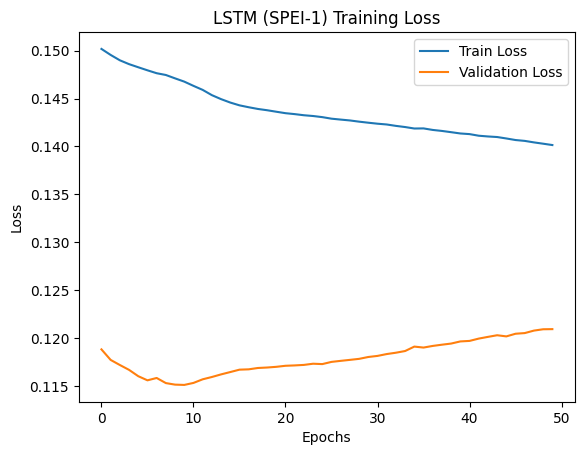

In [202]:
plt.plot(history_spei1.history['loss'], label='Train Loss')
plt.plot(history_spei1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM (SPEI-1) Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


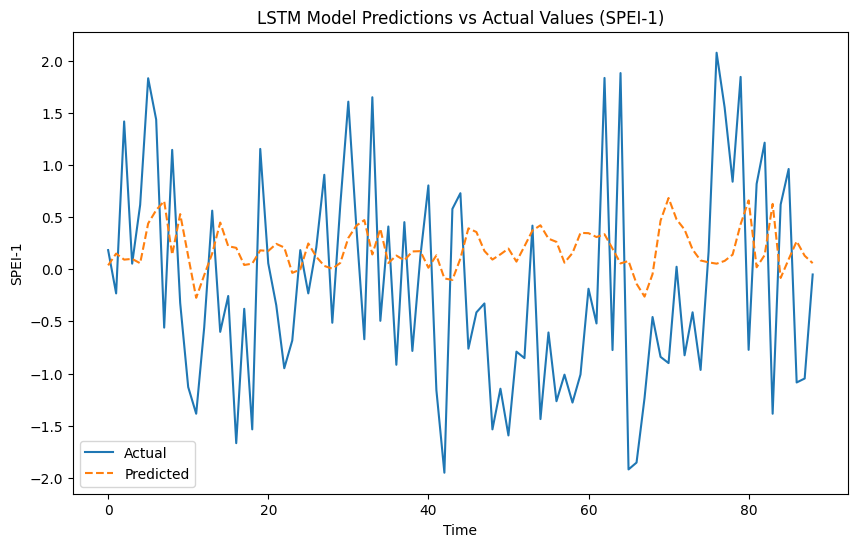

In [ ]:
y_pred_spei1 = LSTM_model_spei1.predict(X_test_spei1) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei1 = scaler.inverse_transform(y_pred_spei1)
y_test_original_spei1 = scaler.inverse_transform(y_test_spei1.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei1, label="Actual")
plt.plot(y_pred_original_spei1, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-1")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-1)")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 


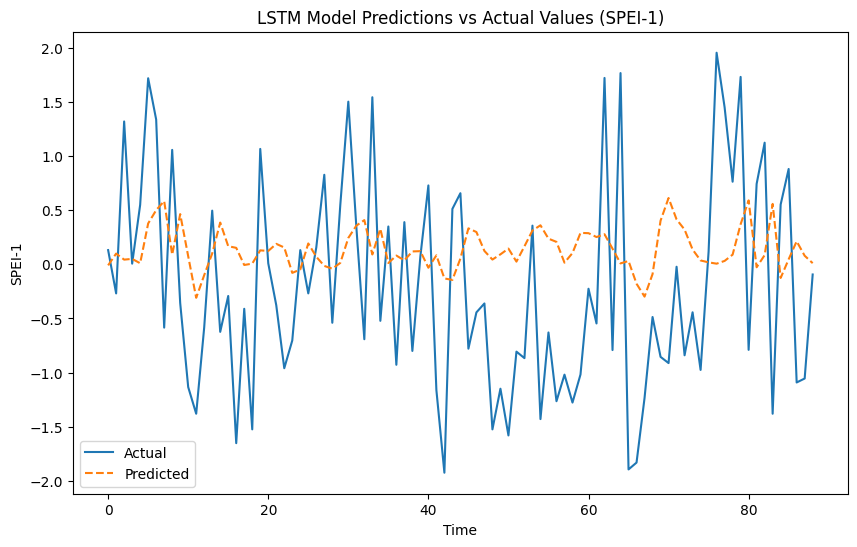

In [205]:
y_pred_spei1 = LSTM_model_spei1.predict(X_test_spei1) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei1 = scaler_spei1.inverse_transform(y_pred_spei1)
y_test_original_spei1 = scaler_spei1.inverse_transform(y_test_spei1.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei1, label="Actual")
plt.plot(y_pred_original_spei1, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-1")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-1)")
plt.show()

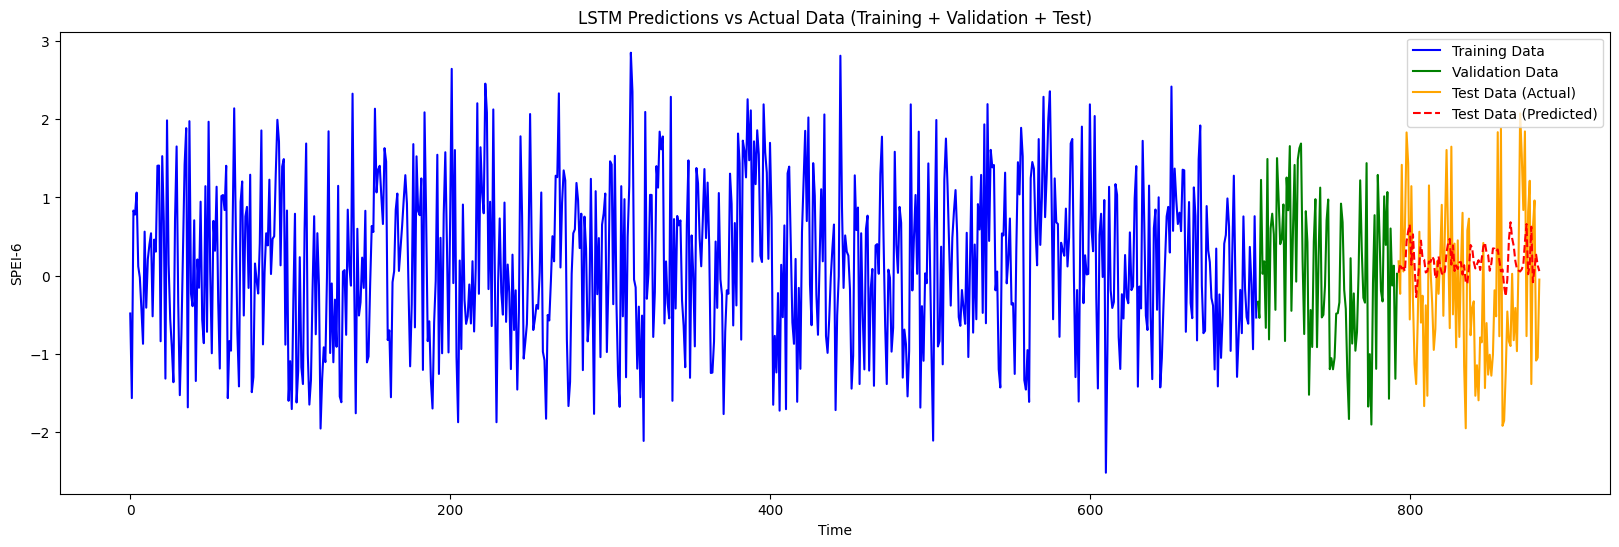

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
reversed_train_data_spei1 = scaler.inverse_transform(y_train_spei1.reshape(-1, 1))
reversed_val_data_spei1 = scaler.inverse_transform(y_val_spei1.reshape(-1, 1))
reversed_test_data_spei1 = scaler.inverse_transform(y_test_spei1.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((reversed_train_data_spei1, reversed_val_data_spei1, reversed_test_data_spei1), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(reversed_train_data_spei1, np.nan),
                                 np.full_like(reversed_val_data_spei1, np.nan),
                                 y_pred_original_spei1), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(reversed_train_data_spei1)), reversed_train_data_spei1, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(reversed_train_data_spei1), len(reversed_train_data_spei1) + len(reversed_val_data_spei1)), reversed_val_data_spei1, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(reversed_train_data_spei1) + len(reversed_val_data_spei1), len(actual_data)), reversed_test_data_spei1, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(reversed_train_data_spei1) + len(reversed_val_data_spei1), len(actual_data)), y_pred_original_spei1, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-6')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

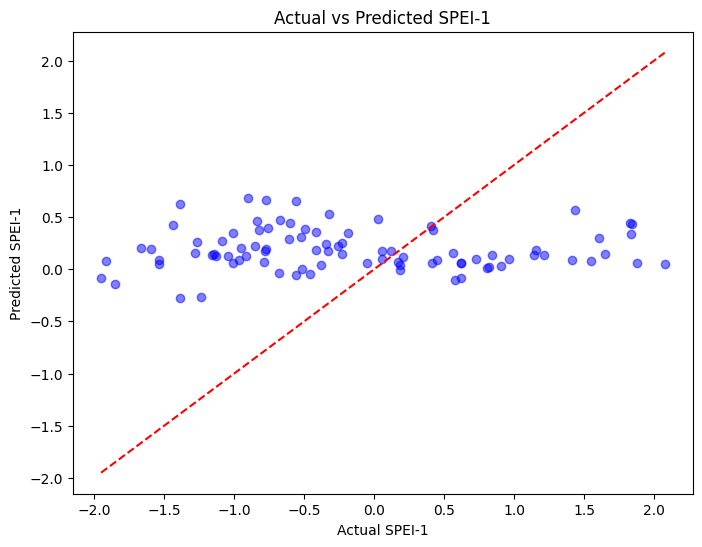

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei1, y_pred_original_spei1, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei1), max(y_test_original_spei1)], [min(y_test_original_spei1), max(y_test_original_spei1)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-1')
plt.ylabel('Predicted SPEI-1')
plt.title('Actual vs Predicted SPEI-1')
plt.show()

#### Metrics

In [ ]:
mae_spei1, mse_spei1, rmse_spei1, r2_spei1 = calculate_metrics(y_test_original_spei1, y_pred_original_spei1)
print(f"Mean Absolute Error: {mae_spei1}")
print(f"Mean Squared Error: {mse_spei1}")
print(f"Root Mean Squared Error: {rmse_spei1}")
print(f"R^2 Score: {r2_spei1}")

Mean Absolute Error: 0.9552191176549726
Mean Squared Error: 1.1891656118938871
Root Mean Squared Error: 1.0904887032399222
R^2 Score: -0.1624315472709874


In [206]:
mae_spei1, mse_spei1, rmse_spei1, r2_spei1 = calculate_metrics(y_test_original_spei1, y_pred_original_spei1)
print(f"Mean Absolute Error: {mae_spei1}")
print(f"Mean Squared Error: {mse_spei1}")
print(f"Root Mean Squared Error: {rmse_spei1}")
print(f"R^2 Score: {r2_spei1}")

Mean Absolute Error: 0.9200003707262466
Mean Squared Error: 1.1030935250508582
Root Mean Squared Error: 1.0502825929486113
R^2 Score: -0.16243155264070053


## LSTM | SPEI-3

### Model Training

In [ ]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei3 = Sequential()
LSTM_model_spei3.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei3.shape[1], 1)))
LSTM_model_spei3.add(LSTM(units=64, activation='relu'))
LSTM_model_spei3.add(Dense(1))
LSTM_model_spei3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei3 = LSTM_model_spei3.fit(X_train_spei3,
                              y_train_spei3,
                              batch_size=16,
                              validation_data=(X_val_spei3, y_val_spei3),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1465 - val_loss: 0.1155
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1326 - val_loss: 0.0864
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1072 - val_loss: 0.0562
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0765 - val_loss: 0.0559
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0715 - val_loss: 0.0573
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0697 - val_loss: 0.0584
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0692 - val_loss: 0.0591
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0690 - val_loss: 0.0595
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0689 - val_loss: 0.0597
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0688 - val_loss: 0.0599
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0688 - val_loss: 0.0600
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0687 - val_loss: 0.

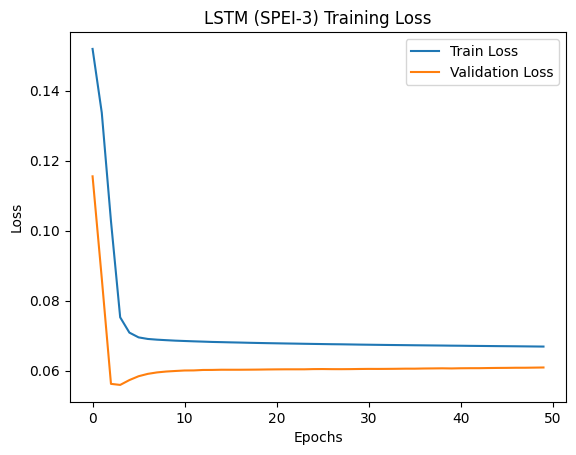

In [ ]:
plt.plot(history_spei3.history['loss'], label='Train Loss')
plt.plot(history_spei3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM (SPEI-3) Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


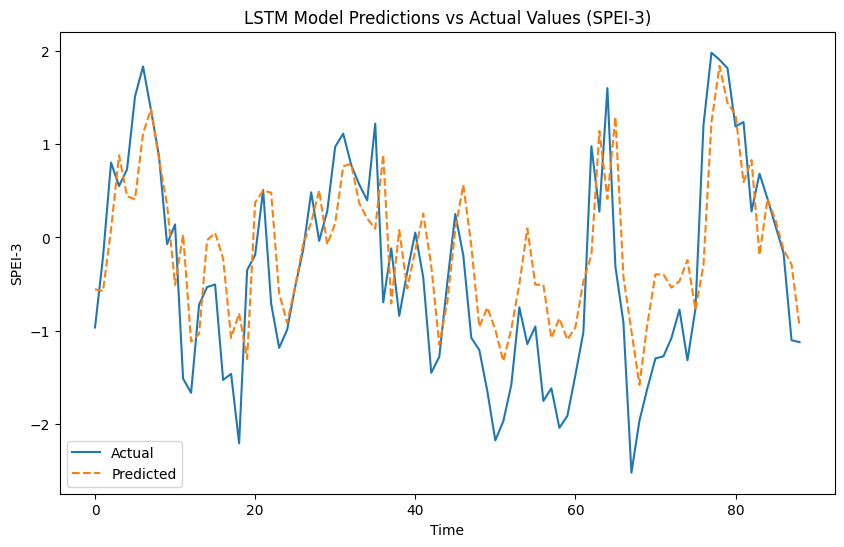

In [ ]:
y_pred_spei3 = LSTM_model_spei3.predict(X_test_spei3) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei3 = scaler.inverse_transform(y_pred_spei3)
y_test_original_spei3 = scaler.inverse_transform(y_test_spei3.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei3, label="Actual")
plt.plot(y_pred_original_spei3, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-3")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-3)")
plt.show()

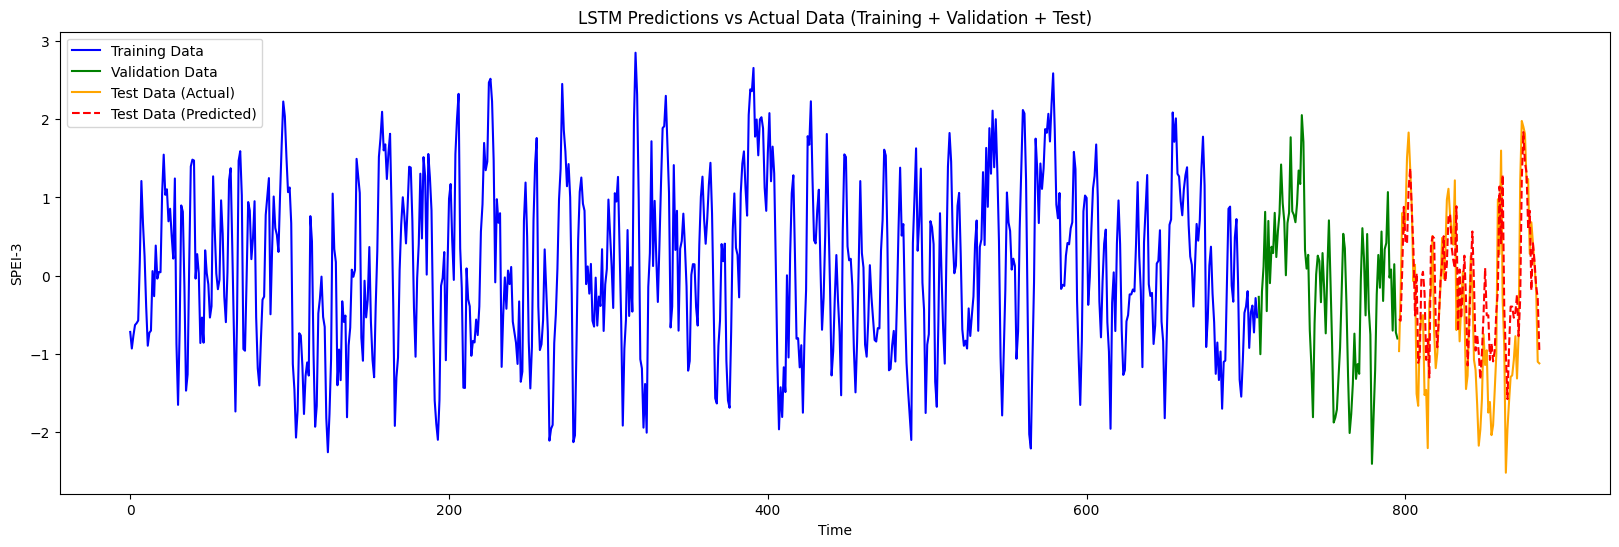

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
reversed_train_data_spei3 = scaler.inverse_transform(y_train_spei3.reshape(-1, 1))
reversed_val_data_spei3 = scaler.inverse_transform(y_val_spei3.reshape(-1, 1))
reversed_test_data_spei3 = scaler.inverse_transform(y_test_spei3.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((reversed_train_data_spei3, reversed_val_data_spei3, reversed_test_data_spei3), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(reversed_train_data_spei3, np.nan),
                                 np.full_like(reversed_val_data_spei3, np.nan),
                                 y_pred_original_spei3), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(reversed_train_data_spei3)), reversed_train_data_spei3, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(reversed_train_data_spei3), len(reversed_train_data_spei3) + len(reversed_val_data_spei3)), reversed_val_data_spei3, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(reversed_train_data_spei3) + len(reversed_val_data_spei3), len(actual_data)), reversed_test_data_spei3, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(reversed_train_data_spei3) + len(reversed_val_data_spei3), len(actual_data)), y_pred_original_spei3, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-3')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

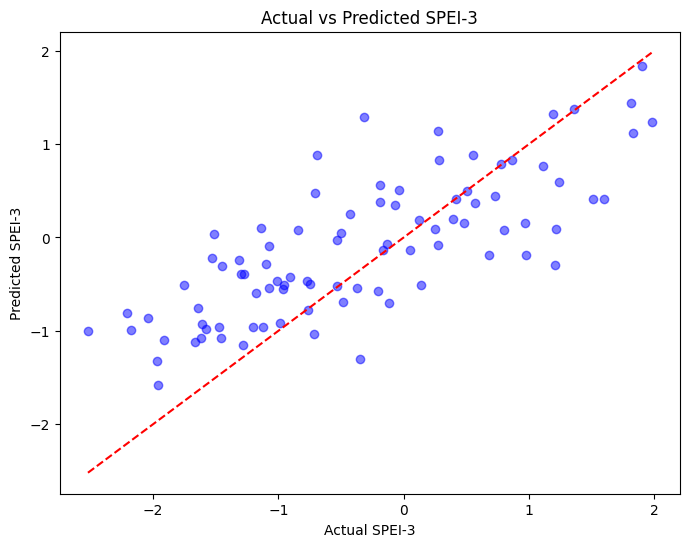

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei3, y_pred_original_spei3, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei3), max(y_test_original_spei3)], [min(y_test_original_spei3), max(y_test_original_spei3)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-3')
plt.ylabel('Predicted SPEI-3')
plt.title('Actual vs Predicted SPEI-3')
plt.show()

#### Metrics

In [ ]:
mae_spei3, mse_spei3, rmse_spei3, r2_spei3 = calculate_metrics(y_test_original_spei3, y_pred_original_spei3)
print(f"Mean Absolute Error: {mae_spei3}")
print(f"Mean Squared Error: {mse_spei3}")
print(f"Root Mean Squared Error: {rmse_spei3}")
print(f"R^2 Score: {r2_spei3}")

Mean Absolute Error: 0.6107028506746599
Mean Squared Error: 0.5623431441839821
Root Mean Squared Error: 0.7498954221649724
R^2 Score: 0.5368602115211354


## LSTM | SPEI-6

### Model Training

In [ ]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei6 = Sequential()
LSTM_model_spei6.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei6.shape[1], 1)))
LSTM_model_spei6.add(LSTM(units=64, activation='relu'))
LSTM_model_spei6.add(Dense(1))
LSTM_model_spei6.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei6 = LSTM_model_spei6.fit(X_train_spei6,
                              y_train_spei6,
                              batch_size=16,
                              validation_data=(X_val_spei6, y_val_spei6),
                              epochs=50,
                              verbose=1, # just determines how much info to display for each epoch
                              shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1357 - val_loss: 0.1305
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1095 - val_loss: 0.0728
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0747 - val_loss: 0.0605
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0655 - val_loss: 0.0482
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0591 - val_loss: 0.0538
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0506 - val_loss: 0.0543
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0503 - val_loss: 0.0570
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0491 - val_loss: 0.0554
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0470 - val_loss: 0.0515
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0459 - val_loss: 0.0481
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0450 - val_loss: 0.0454
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.044

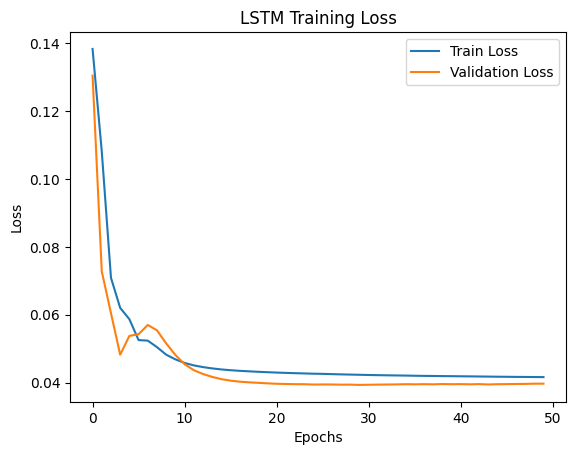

In [ ]:
plt.plot(history_spei6.history['loss'], label='Train Loss')
plt.plot(history_spei6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


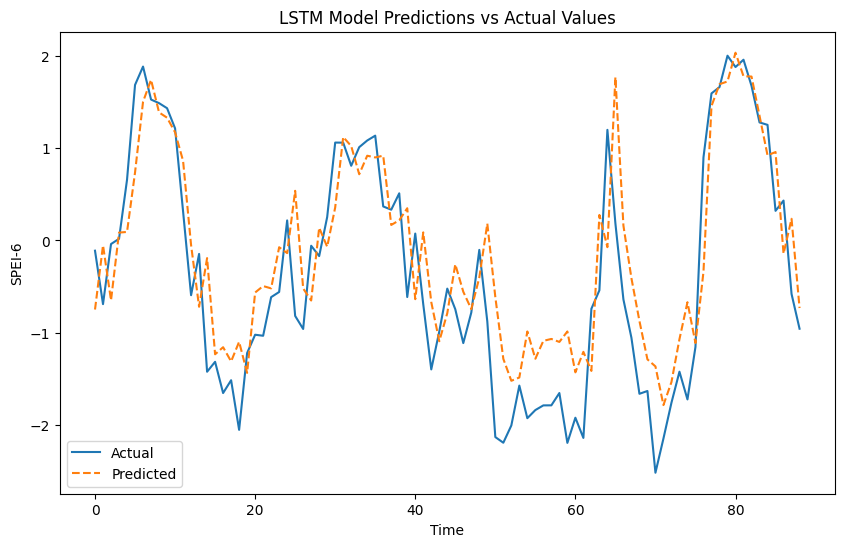

In [ ]:
y_pred_spei6 = LSTM_model_spei6.predict(X_test_spei6) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei6 = scaler.inverse_transform(y_pred_spei6)
y_test_original_spei6 = scaler.inverse_transform(y_test_spei6.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei6, label="Actual")
plt.plot(y_pred_original_spei6, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

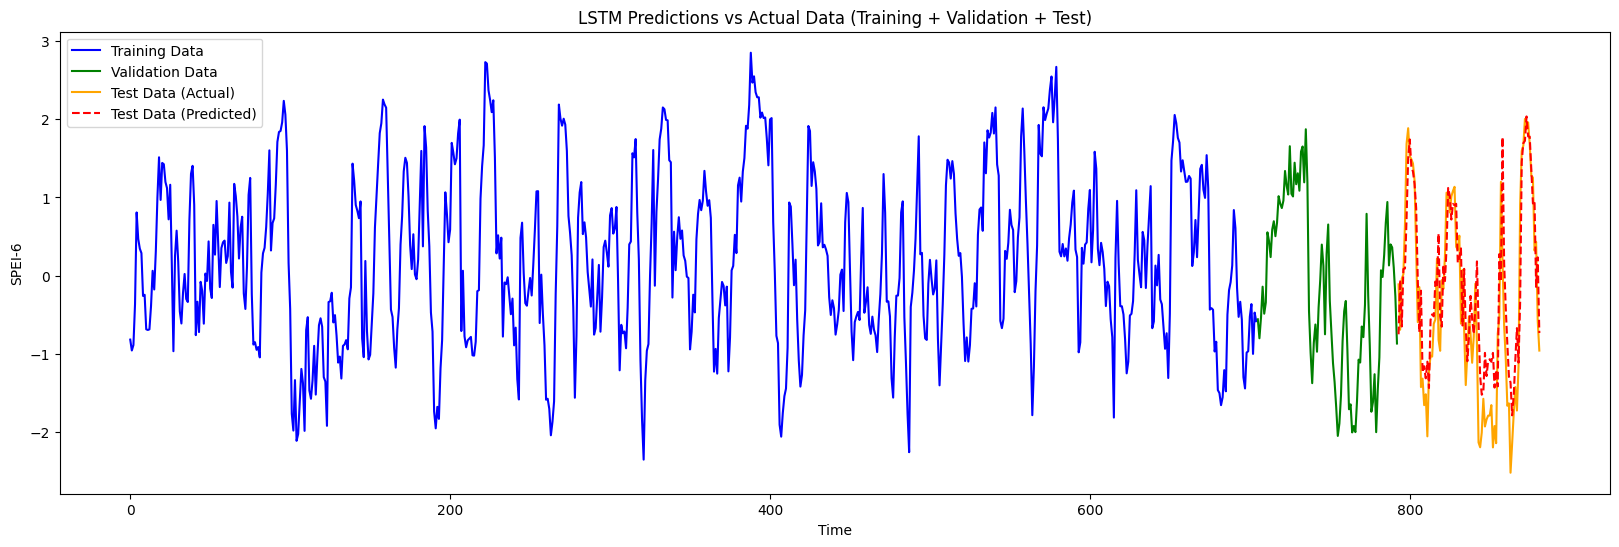

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
train_data1 = scaler.inverse_transform(y_train_spei6.reshape(-1, 1))
val_data1 = scaler.inverse_transform(y_val_spei6.reshape(-1, 1))
test_data1 = scaler.inverse_transform(y_test_spei6.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((train_data1, val_data1, test_data1), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(train_data1, np.nan),
                                 np.full_like(val_data1, np.nan),
                                 y_pred_original_spei6), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(train_data1)), train_data1, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(train_data1), len(train_data1) + len(val_data1)), val_data1, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), test_data1, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), y_pred_original_spei6, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-6')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

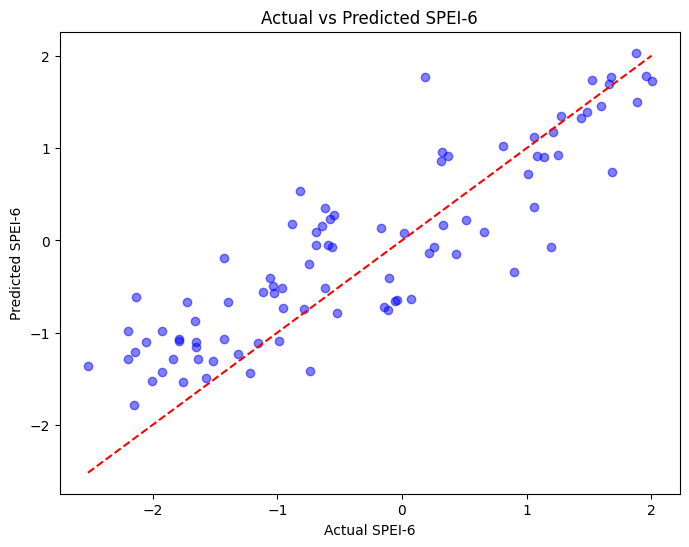

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei6, y_pred_original_spei6, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei6), max(y_test_original_spei6)], [min(y_test_original_spei6), max(y_test_original_spei6)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-6')
plt.ylabel('Predicted SPEI-6')
plt.title('Actual vs Predicted SPEI-6')
plt.show()

#### Metrics

In [ ]:
mae_spei6, mse_spei6, rmse_spei6, r2_spei6 = calculate_metrics(y_test_original_spei6, y_pred_original_spei6)
print(f"Mean Absolute Error: {mae_spei6}")
print(f"Mean Squared Error: {mse_spei6}")
print(f"Root Mean Squared Error: {rmse_spei6}")
print(f"R^2 Score: {r2_spei6}")

Mean Absolute Error: 0.5259981029040373
Mean Squared Error: 0.414566784712614
Root Mean Squared Error: 0.6438686082677226
R^2 Score: 0.7331778615773087


## LSTM | SPEI-12

### Model Training

In [ ]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model_spei12 = Sequential()
LSTM_model_spei12.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train_spei12.shape[1], 1)))
LSTM_model_spei12.add(LSTM(units=64, activation='relu'))
LSTM_model_spei12.add(Dense(1))
LSTM_model_spei12.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_spei12 = LSTM_model_spei12.fit(X_train_spei12,
                                      y_train_spei12,
                                      batch_size=16,
                                      validation_data=(X_val_spei12, y_val_spei12),
                                      epochs=50,
                                      verbose=1, # just determines how much info to display for each epoch
                                      shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1029 - val_loss: 0.1109
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0663 - val_loss: 0.0381
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0498 - val_loss: 0.0228
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0421 - val_loss: 0.0194
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0327 - val_loss: 0.0181
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0345 - val_loss: 0.0239
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0268 - val_loss: 0.0141
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264 - val_loss: 0.0139
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - val_loss: 0.0131
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0220 - val_loss: 0.0133
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - val_loss: 0.0129
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0211 - val_l

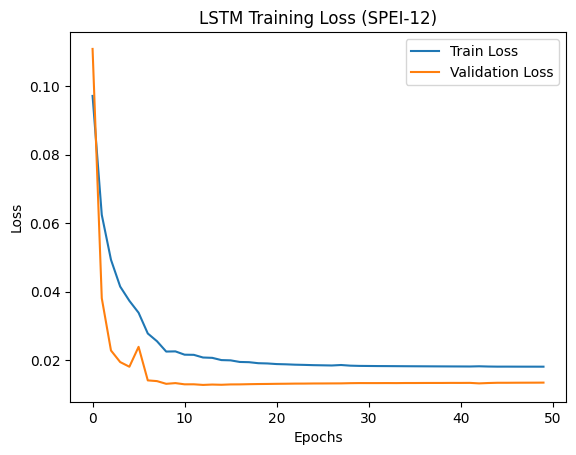

In [ ]:
plt.plot(history_spei12.history['loss'], label='Train Loss')
plt.plot(history_spei12.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss (SPEI-12)')
plt.show()

### Evaluation

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


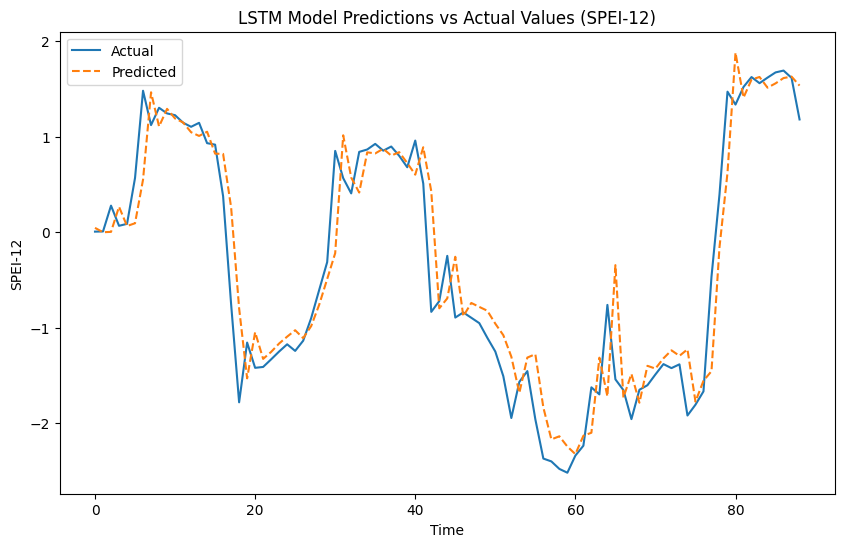

In [ ]:
y_pred_spei12 = LSTM_model_spei12.predict(X_test_spei12) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original_spei12 = scaler.inverse_transform(y_pred_spei12)
y_test_original_spei12 = scaler.inverse_transform(y_test_spei12.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_spei12, label="Actual")
plt.plot(y_pred_original_spei12, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-12")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values (SPEI-12)")
plt.show()

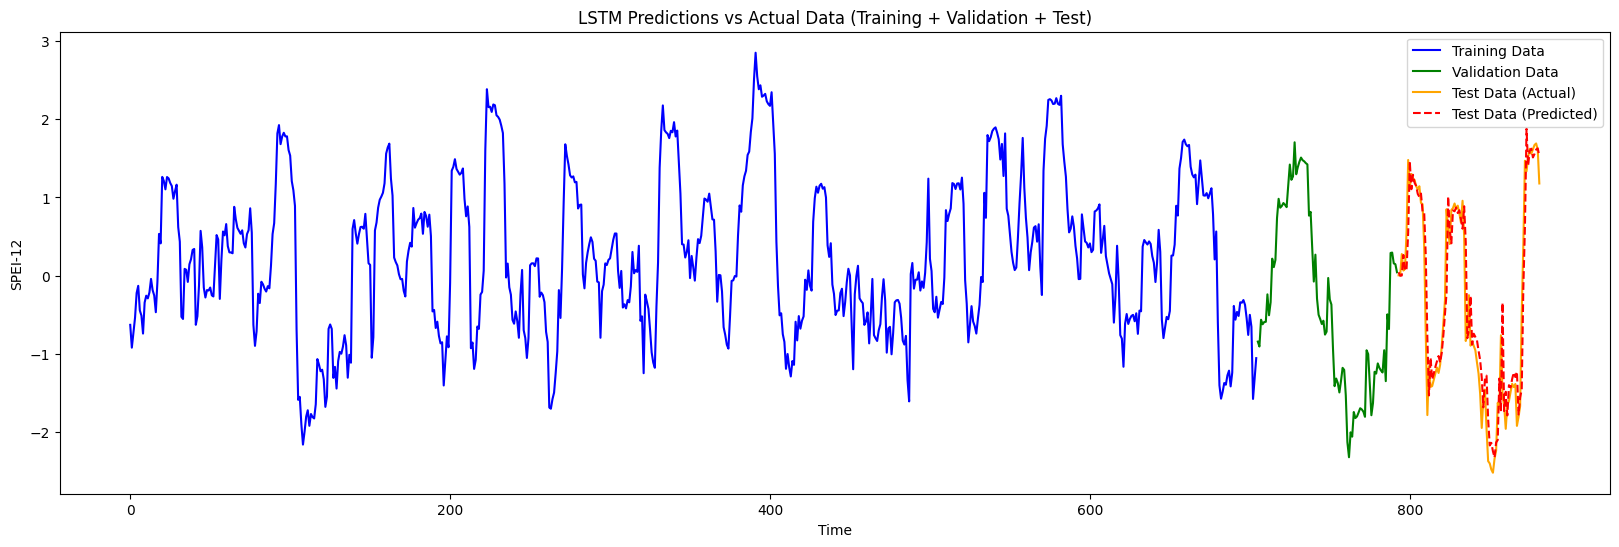

In [ ]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
normal_train_data_spei12 = scaler.inverse_transform(y_train_spei12.reshape(-1, 1))
normal_val_data_spei12 = scaler.inverse_transform(y_val_spei12.reshape(-1, 1))
normal_test_data_spei12 = scaler.inverse_transform(y_test_spei12.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data_spei12 = np.concatenate((normal_train_data_spei12, normal_val_data_spei12, normal_test_data_spei12), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data_spei12 = np.concatenate((np.full_like(normal_train_data_spei12, np.nan),
                                 np.full_like(normal_val_data_spei12, np.nan),
                                 y_pred_original_spei12), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(normal_train_data_spei12)), normal_train_data_spei12, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(normal_train_data_spei12), len(normal_train_data_spei12) + len(normal_val_data_spei12)), normal_val_data_spei12, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(normal_train_data_spei12) + len(normal_val_data_spei12), len(actual_data)), normal_test_data_spei12, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(normal_train_data_spei12) + len(normal_val_data_spei12), len(actual_data)), y_pred_original_spei12, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-12')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

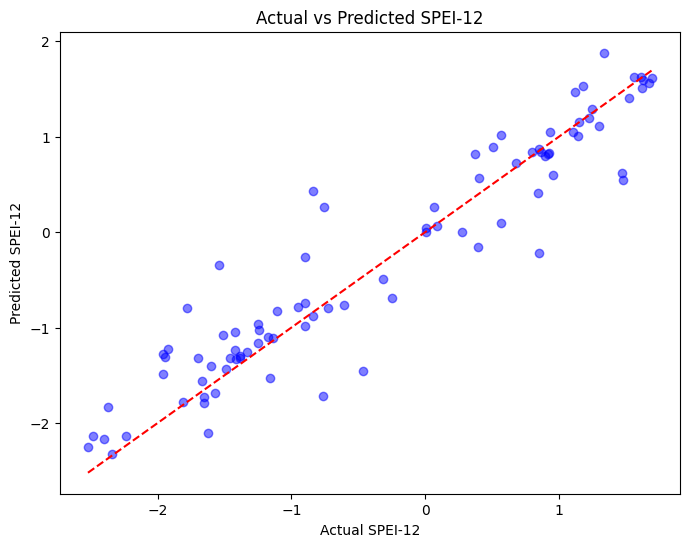

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_spei12, y_pred_original_spei12, color='blue', alpha=0.5)
plt.plot([min(y_test_original_spei12), max(y_test_original_spei12)], [min(y_test_original_spei12), max(y_test_original_spei12)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-12')
plt.ylabel('Predicted SPEI-12')
plt.title('Actual vs Predicted SPEI-12')
plt.show()

#### Metrics

In [ ]:
mae_spei12, mse_spei12, rmse_spei12, r2_spei12 = calculate_metrics(y_test_original_spei12, y_pred_original_spei12)
print(f"Mean Absolute Error: {mae_spei12}")
print(f"Mean Squared Error: {mse_spei12}")
print(f"Root Mean Squared Error: {rmse_spei12}")
print(f"R^2 Score: {r2_spei12}")

Mean Absolute Error: 0.29373200591515486
Mean Squared Error: 0.17941383938380137
Root Mean Squared Error: 0.423572708497374
R^2 Score: 0.8912566920478844
